In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("Traffic.ipynb")

# Final Project: Traffic
## Due Date: Monday, December 13th, 11:59 PM
## Collaboration Policy

Data science is a collaborative activity. While you may talk with other groups about
the project, we ask that you **write your solutions within your own groups**. If you do
discuss the assignments with others outside of your group please **include their names** at the top
of your notebook.

# Data 100 Final Project: Traffic in a post-lockdown world

**Scenario:** You're a data scientist at Uber -- sitting in a war room on March 16, 2020, 1 day after California-wide COVID lockdown measures began and the day shelter-in-place measures are announced in the bay area. The entire data science department is on fire: All of your existing traffic models have regressed *significantly*. Given the sudden change in traffic patterns (i.e., no traffic at all), the company's traffic estimates are wildly incorrect. This is a top priority for the company. Since traffic estimates are used directly for pricing strategies, this is actively costing the company millions every hour. You are tasked with fixing these models.

**Takeaways:** How do you "fix" models that have learned biases from pre-lockdown traffic? How do you train new ones, with just 24 hours of data? What sorts of data do you examine, to better understand the situation? In the midst of company-wide panic, you'll need a strong inferential acumen to lead a robust data science response. In this project, we'll walk you through a simulated war room data science effort, culminating in some strategies to fix models online, which are experiencing large distributional shifts in data.

For this project, we'll explore traffic data provided by the **Uber Movement** dataset, specifically around the start of COVID shutdowns in March 2020. Your project is structured around the following ideas:

```
1. Guided data cleaning: Clustering data spatially
    a. Load Uber traffic speeds dataset
    b. Map traffic speeds to Google Plus Codes (spatially uniform)
        i. Load node-to-gps-coordinates data
        ii. Map traffic speed to GPS coordinates
        iii. Convert GPS coordinates to plus code regions
        iv. Sanity check number of plus code regions in San Francisco
        v. Plot a histogram of the standard deviation in speed, per plus code region.
    c. Map traffic speeds to census tracts (spatially non-uniform)
        i. Download census tracts geojson
        ii. Map traffic speed to census tracts
        iii. Sanity check number of census tracts in San Francisco with data.
        iv. Plot a histogram of the standard deviation in speed, per census tract.
    d. What defines a "good" or "bad" spatial clustering?
2. Guided EDA: Understanding COVID lockdown impact on traffic
    a. How did lockdown affect average traffic speeds?
        i. Sort census tracts by average speed, pre-lockdown.
        ii. Sort census tracts by average speed, post-lockdown.
        iii. Sort census tracts by change in average speed, from pre to post lockdown.
        iv. Quantify the impact of lockdown on average speeds.
        v. Quantify the impact of pre-lockdown average speed on change in speed.
    b. What traffic areas were impacted by lockdown?
        i. Visualize heatmap of average traffic speed per census tract, pre-lockdown.
        ii. Visualize change in average daily speeds pre vs. post lockdown.
        iii. Quantify the impact of lockdown on daily speeds, spatially.
3. Open-Ended EDA: Understanding lockdown impact on traffic times
    a. Download Uber Movement (Travel Times) dataset
4. Guided Modeling: Predict traffic speed post-lockdown
    a. Predict daily traffic speed on pre-lockdown data
        i. Assemble dataset to predict daily traffic speed.
        ii. Train and evaluate linear model on pre-lockdown data.
    b. Understand failures on post-lockdown data
        i. Evaluate on post-lockdown data
        ii. Report model performance temporally
    c. "Fix" model on post-lockdown data
        i. Learn delta off of a moving bias
        ii. Does it "solve itself"? Does the pre-lockdown model predict, after the change point?
        iii. Naively retrain model with post-lockdown data
        iv. What if you just ignore the change point?
5. Open-Ended Modeling: Predicting travel times post-lockdown
```

Concepts tested: regex, pivot, join, grouping, inferential thinking

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import csv
import json
import os
import contextily as cx
from collections import defaultdict
import re
from typing import Callable

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

from zipfile import ZipFile
zf = ZipFile('data.zip', 'r')
zf.extractall('.')

# more readable exceptions
%pip install --quiet iwut
%load_ext iwut
%wut on

Note: you may need to restart the kernel to use updated packages.


# Step 1 - Guided Data Cleaning: Partitioning Data Spatially

Our hope is answer: How do we group information spatially? We'll specifically look at 2 ways of partitioning data spatially, to understand the impact of spatial partitioning strategies on our analyses:

1. Dividing the world uniformly into slices, like Google's plus codes.
2. Dividing the world according to population, using census tracts.

In this step, we'll load the following datasets that we'll need for this project:

- Daily travel times from Uber Movement data in March 2020 from San Francisco, by census tract
- Daily traffic speeds from Uber Movement data in Q1 2020 from San Francisco, between OSM nodes
- Census tracts dividing San Francisco by GPS coordinates
- Mapping from OSM nodes to GPS coordinates

There are several terms and concepts to get familiar with upfront:

- **Open Street Maps (OSM)** provides nodes (points in space, [wiki](https://wiki.openstreetmap.org/wiki/Node)) and ways (segments between nodes [wiki](https://wiki.openstreetmap.org/wiki/Way)). These IDs are used in the Uber Movement dataset to identify streets in the traffic speeds dataset.
- **Census Tracts** provided by the county of San Francisco geographically divides space according to the US 2010 Census. This is used in the Uber Movement dataset to identify regions of differing travel times.

## 1.a. Load Uber traffic speeds dataset

The dataset is located at `data/movement-speeds-daily-san-francisco-2020-3.csv`. **Load this dataset into a dataframe.**

*The original dataset from Uber was provided hourly and took up 2.1 GB on disk, which means it couldn't fit into your 1GB of RAM. You can find the dataset preparation script at `data/PrepareTrafficDataset.ipynb` which aggregated within each day, reducing the dataset to just 55MB on disk.*

*This was originally going to be question in this project, but it takes 22 minutes to run. Better yet, if you mess up, your kernel dies and you start over. We deemed it too frustrating and preprocessed the dataset to spare you the pain... but just know that this is a real-world issue!*

<!--
BEGIN QUESTION
name: q1a
points: 1
-->

In [3]:
# Load Uber Movement (Movement Speeds) dataset into dataframe
speeds_to_nodes = pd.read_csv("data/movement-speeds-daily-san-francisco-2020-3.csv")

speeds_to_nodes

,osm_start_node_id,osm_end_node_id,day,speed_mph_mean
0,281266,702258940,1,59.674042
1,281266,702274215,1,68.444042
2,302876,240259516,1,66.446500
3,302878,437325360,1,65.516850
4,302883,65381191,1,61.880556
...,...,...,...,...
1586647,6569140748,1350115374,31,68.484833
1586648,6570476556,4551993266,31,36.837000
1586649,6573249373,4911384010,31,39.021000
1586650,6573553681,256888796,31,68.728333


In [4]:
grader.check("q1a")

q1a results: All test cases passed!

<!-- BEGIN QUESTION -->

## 1.b. Map traffic speed to Google Plus Codes

Google Plus Codes divide up the world uniformly into rectangular slices ([link](https://maps.google.com/pluscodes/)). Let's use this to segment traffic speeds spatially. Take a moment to answer: **Is this spatial structure effective for summarizing traffic speed?** Before completing this section, substantiate your answer with examples of your expectations (e.g., we expect A to be separated from B). After completing this section, substantiate your answer with observations you've made.

<!--
BEGIN QUESTION
name: q1b
points: 2
manual: True
-->

I expect this spatial structure to be effective for summarizing traffic speed because different areas or plus codes are more popular for people to visit than others. For instance, around more popular areas, such as Union Square, there will be more traffic because there is more demand for travelling to this area, while less popular areas, such as residetial areas, will have less traffic.

<!-- END QUESTION -->



### 1.b.i. Load Node-to-GPS-Coordinate Data

In this substep, we'll load a mapping from OSM nodes to GPS coordinates. The dataset is provided in a gzip'ed XML file from OpenStreetMaps (OSM). The mapping from OSM nodes to GPS coordinates was downloaded from https://download.bbbike.org/osm/bbbike/SanFrancisco/SanFrancisco.osm.gz. We've downloaded this for you, to avoid any issues with OSM updates.

**If** you try to load the provided `.osm` (an `.xml` in disguise) using Python's built-in XML utilities **(by uncommenting the last 2 lines in the below cell)**, you will hit an out-of-memory error, as your kernel is forced to restart.

In [5]:
# [OSM] - Read the OSM XML and extract mapping from node ID to GPS coordinates
PATH_OSM = os.path.expanduser('data/SanFrancisco.osm')

# Runs out of memory! File itself is 430 MB, even when filtering out
# irrelevant rows, and remaining 3M rows are too expensive to parse,
# resulting in OOM

# import xml.etree.ElementTree as ET
# _tree = ET.parse(PATH_OSM)

Your above code hits a memory error, so instead, we will use our handy-dandy tool--regex--from earlier in the semester to load just the parts of the file that we need. **Given the XML snippet below, write a regex pattern to extract OSM node ID, latitude, and longitude.** (The first capture group should be node ID. The second should be latitude, and the third should be longitude.) A snippet of the XML is included below ([screenshot](https://extract.bbbike.org/extract-screenshots.html)):

```
<?xml version='1.0' encoding='UTF-8'?>
<osm version="0.6" generator="osmconvert 0.8.3">
    <bounds minlat="42.4543" minlon="-2.4761999" maxlat="42.4..."/>
    <node id="26861066" lat="42.471111" lon="-2.454722" version="..."/>
        <tag k="name" v="Camping La Playa"/>
        <tag k="tourism" v="camp_site"/>
        <tag k="operator" v="private"/>
        ...
    </node>
    <node id="34793287" lat="42.4713587" lon="-2.4510783" version="..."/>
        <tag k="created_by" v="JOSM"/>
    </node>
    <node id="34793294" lat="42.4610836" lon="-2.4303622" version="..."/>
    <node id="34793297" lat="42.4548363" lon="-2.4287657" version="..."/>
    ...
</osm>
```

In [6]:
# [OSM] - Read the OSM XML using a regex operation instead.
def read_node_lat_lon(path: str, pattern: str, line_condition: Callable):
    """
    Read the provided path line at a line. If the provided regex pattern
    has a match, return the grouped matches as items in a generator.
    
    :param path: Path to read data from
    :param pattern: Regex pattern to test against each line
    :param line_condition: function that returns if we should check regex
        against current line
    """
    with open(path) as f:
        for line in f:
            result = re.search(pattern, line)
            if result is not None and line_condition(result):
                yield int(result.group(1)), float(result.group(2)), float(result.group(3))

In [7]:
node_ids = set(speeds_to_nodes.osm_start_node_id) | set(speeds_to_nodes.osm_end_node_id)

NODE_PATTERN = r"id=\"(\d+\.*\d*)\"\slat=\"(\d+\.*\d*)\"\slon=\"([-]*\d+\.*\d*)"

node_to_gps = pd.DataFrame(read_node_lat_lon(
    PATH_OSM,
    pattern=NODE_PATTERN,
    line_condition=lambda result: int(result.group(1)) in node_ids
), columns=['osm_node_id', 'Latitude', 'Longitude'])
node_to_gps

,osm_node_id,Latitude,Longitude
0,26118026,37.675280,-122.389194
1,29891973,37.674935,-122.389130
2,29892598,37.716892,-122.398893
3,30033679,37.599877,-122.376497
4,30033686,37.642167,-122.405946
...,...,...,...
19139,6522255428,37.760543,-122.443563
19140,6522255492,37.759317,-122.444996
19141,6522764204,37.762163,-122.436143
19142,6522764212,37.756061,-122.436761


In [8]:
grader.check("q1bi")

q1bi results: All test cases passed!

### 1.b.ii. Map traffic speed to GPS coordinates.

Traffic speeds are currently connected to OSM nodes. You will then use the mapping from OSM nodes to GPS coordinates, to map traffic speeds to GPS coordinates. **Link each traffic speed measurement to the GPS coordinate of its starting node.**

**Note**: For simplicity, assume each segment is associated with the node it *starts* with. 

**Hint**: Not all nodes are included in the OSM node mapping. Make sure to ignore any nodes without valid GPS coordinates.

<!--
BEGIN QUESTION
name: q1bii
points: 3
-->

In [9]:
# Find mapping from traffic speeds to GPS coordinates
speeds_to_gps = speeds_to_nodes.join(node_to_gps.set_index("osm_node_id"), on = "osm_start_node_id").dropna()
speeds_to_gps

,osm_start_node_id,osm_end_node_id,day,speed_mph_mean,Latitude,Longitude
141,26118026,259458979,1,64.478000,37.675280,-122.389194
233,29891973,434338966,1,67.489083,37.674935,-122.389130
234,29892598,1659365989,1,64.466458,37.716892,-122.398893
254,30033679,250031600,1,63.353364,37.599877,-122.376497
255,30033686,65370191,1,65.178000,37.642167,-122.405946
...,...,...,...,...,...,...
1586575,6502733624,260168596,31,33.423071,37.712530,-122.469258
1586597,6514737752,65328721,31,13.657500,37.797736,-122.407748
1586598,6522241813,6522255331,31,25.630000,37.757936,-122.443498
1586599,6522255331,6522255406,31,27.393000,37.757876,-122.443423


In [10]:
grader.check("q1bii")

q1bii results: All test cases passed!

### 1.b.iii. Convert GPS coordinates to plus code regions.

Plus code regions divide up the world into uniformly-sized rectangles, which we will assume is 0.012 degrees latitudiunally and longitudinally. **For each traffic speed row, compute the plus code region it belongs to**, based on its GPS coordinates.

To do this, we suggest computing a latitudinal index `plus_latitude_idx` and a longitudinal index `plus_longitude_idx` for the plus code region each row belongs to. *Make sure these columns are integer-valued*.

**Hint**: If you're running into nans, you did 1.b.ii. incorrectly!

<!--
BEGIN QUESTION
name: q1biii
points: 3
-->

In [11]:
... # do this however you like
speeds_to_gps['plus_latitude_idx'] = (speeds_to_gps['Latitude']/0.012).astype(int)
speeds_to_gps['plus_longitude_idx'] = (speeds_to_gps['Longitude']/0.012).astype(int)
speeds_to_gps

,osm_start_node_id,osm_end_node_id,day,speed_mph_mean,Latitude,Longitude,plus_latitude_idx,plus_longitude_idx
141,26118026,259458979,1,64.478000,37.675280,-122.389194,3139,-10199
233,29891973,434338966,1,67.489083,37.674935,-122.389130,3139,-10199
234,29892598,1659365989,1,64.466458,37.716892,-122.398893,3143,-10199
254,30033679,250031600,1,63.353364,37.599877,-122.376497,3133,-10198
255,30033686,65370191,1,65.178000,37.642167,-122.405946,3136,-10200
...,...,...,...,...,...,...,...,...
1586575,6502733624,260168596,31,33.423071,37.712530,-122.469258,3142,-10205
1586597,6514737752,65328721,31,13.657500,37.797736,-122.407748,3149,-10200
1586598,6522241813,6522255331,31,25.630000,37.757936,-122.443498,3146,-10203
1586599,6522255331,6522255406,31,27.393000,37.757876,-122.443423,3146,-10203


In [12]:
grader.check("q1biii")

q1biii results: All test cases passed!

### 1.b.iv. Sanity check number of plus code regions in San Francisco.

**Compute the number of unique plus codes found in your dataset**. You're checking that the number isn't ridiculous, like 1, or 100,000 (SF is 231 sq mi, so 100k tracts would average 12 sq ft per tract).

If you followed the suggestion above, this is the number of unique `(plus_latitude_idx, plus_longitude_idx)` pairs.

<!--
BEGIN QUESTION
name: q1biv
points: 4
-->

In [13]:
# You're expecting 276 plus codes here. Don't just type "276" 
# below to pass the autograder. The goal is to sanity check your 
# dataframe!
num_pluscode_regions = len(speeds_to_gps.groupby(["plus_latitude_idx", "plus_longitude_idx"]).size())
num_pluscode_regions

276

In [14]:
grader.check("q1biv")

q1biv results: All test cases passed!

<!-- BEGIN QUESTION -->

### 1.b.v. How well do plus code regions summarize movement speeds?

The following will give us an idea of how well the average represents traffic speed per plus code region. For these questions, we'll refer to a "plus code region" as a "cluster":

1. **Plot a histogram of the within-cluster standard deviation**.
2. **Compute across-cluster average of within-cluster standard deviation**.
3. **Compute across-cluster standard deviation of within-cluster average speeds**.
4. **Is this average variance reasonable?** To assess what "reasonable" means, consider these questions and how to answer them: (1) Do plus codes capture meaningful subpopulations? (2) Do differences between subpopulations outweigh differences within a subpopulation? Use the statistics above to answer these questions, and compute any additional statistics you need. Additionally explain *why these questions are important to assessing the quality of a spatial clustering*.

**Hint**: Run the autograder first to ensure your variance average and average variance are correct, before starting to draw conclusions.

In the first cell, write your written answers. In the second cell, complete the code.

<!--
BEGIN QUESTION
name: q1bv1
points: 2
manual: True
-->



I think the average variance is reasonable. Based on our data, across-cluster standard deviation of within cluster average speeds was greater than the across cluster average of within cluster standard deviation, which tells us that clusters differ more with each other compared to the population within itself. Yes, differences between subpopulations do outweigh differences within a subpopulation, and this can be attributed to the demographics of the people and driving speeds within a cluster. This information may tell us that it would be more effective to utilize spatial clustering by plus codes since our data seems to suggest there is less variation within a cluster than between clusters.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!--
BEGIN QUESTION
name: q1bv2
points: 2
manual: True
-->

(8.684748294968637, 10.13573858675904)

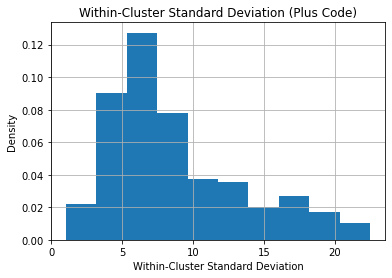

In [15]:
speed_variance_by_pluscode = speeds_to_gps.groupby(["plus_latitude_idx", "plus_longitude_idx"]).aggregate(np.std).reset_index()["speed_mph_mean"]# compute traffic speed variance in each plus code region
speed_variance_by_pluscode.hist(density = True)
plt.title("Within-Cluster Standard Deviation (Plus Code)")
plt.xlabel("Within-Cluster Standard Deviation")
plt.ylabel("Density")# plot a histogram
average_variance_by_pluscode = np.mean(speed_variance_by_pluscode)
variance_average_by_pluscode = speeds_to_gps.groupby(["plus_latitude_idx", "plus_longitude_idx"]).aggregate(np.mean).reset_index()["speed_mph_mean"].std()
average_variance_by_pluscode, variance_average_by_pluscode

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q1bv3
points: 3
-->

In [16]:
speed_variance_by_pluscode

0       3.650232
1      20.704487
2      12.342234
3       4.083821
4      21.390912
         ...    
271    15.293632
272    17.915911
273    14.243592
274    12.237229
275    17.590817
Name: speed_mph_mean, Length: 276, dtype: float64

In [17]:
grader.check("q1bv3")

q1bv3 results: All test cases passed!

## 1.c. Map traffic speed to census tract.

Census tracts divide the space much less uniformly, subdividing regions that we were interested in into smaller zones. This suggests promise in providing informative spatial segments. Note that the daily traffic speeds are provided between OpenStreetMap (OSM) nodes, so we'll need to map nodes to census tracts somehow.

Above, we've mapped traffic speeds to GPS coordinates. Below, we'll then link GPS coordinates to census tracts, to complete the mapping from traffic speeds to census tracts.

### 1.c.i. Download Census Tracts Geojson

**Load the census tracts geojson.** Make sure to see the relevant [geopandas io documentation](https://geopandas.org/docs/user_guide/io.html) to see how to load a geojson.

**Hint**: It should take you just one line to load.

<!--
BEGIN QUESTION
name: q1ci
points: 1
-->

In [18]:
PATH_TRACTS = os.path.expanduser('data/san_francisco_censustracts.json')
tract_to_gps = gpd.read_file(PATH_TRACTS)
tract_to_gps['MOVEMENT_ID'] = tract_to_gps['MOVEMENT_ID'].astype(int)
tract_to_gps

,MOVEMENT_ID,DISPLAY_NAME,geometry
0,1,"Sargent Creek, San Ardo","MULTIPOLYGON (((-121.59511 36.11126, -121.5401..."
1,2,"400 Northumberland Avenue, Redwood Oaks, Redwo...","MULTIPOLYGON (((-122.22463 37.46507, -122.2236..."
2,3,"18300 Sutter Boulevard, Morgan Hill","MULTIPOLYGON (((-121.67978 37.15859, -121.6719..."
3,4,"2700 Stoughton Way, Sheffield, Sacramento","MULTIPOLYGON (((-121.35921 38.57175, -121.3462..."
4,5,"3200 Huntsman Drive, Rosemont Park, Sacramento","MULTIPOLYGON (((-121.37512 38.55309, -121.3715..."
...,...,...,...
2705,2706,"10000 Bobbell Drive, Elk Grove","MULTIPOLYGON (((-121.48392 38.40874, -121.4787..."
2706,2707,"400 Ericwood Court, Manteca","MULTIPOLYGON (((-121.22695 37.82647, -121.2185..."
2707,2708,"200 Westview Drive, Sunshine Gardens, South Sa...","MULTIPOLYGON (((-122.45179 37.66912, -122.4506..."
2708,2709,"1200 Halyard Drive, West Sacramento","MULTIPOLYGON (((-121.58346 38.57860, -121.5827..."


In [19]:
grader.check("q1ci")

q1ci results: All test cases passed!

### 1.c.ii Map traffic speed to census tracts.

You will need to *spatially join* the (1) mapping from traffic speed to GPS coordinates `speed_to_gps` and (2) the mapping from GPS coordinates to boundaries of census tracts `tract_to_gps` to group all traffic speeds by census tract. This "spatial join" is an advanced feature recently released (as of time of writing, in Oct 2021) in geopandas, which allows us to connect single points to their enclosing polygons. You will do this question in 3 parts:

1. Convert the last dataframe `speeds_to_gps` into a geopandas dataframe `speeds_to_points`, where GPS coordinates are now geopandas points. See this tutorial: https://geopandas.org/gallery/create_geopandas_from_pandas.html#From-longitudes-and-latitudes
2. Set the coordinate-system for the new geopandas dataframe to the "world geodesic system" [link](https://epsg.io/4326), or in other words, the coordinate system that GPS coordinates are reported in.
3. Compute a spatial join between census tracts `tract_to_gps` and the geopandas traffic speeds `speeds_to_points`

<!--
BEGIN QUESTION
name: q1cii
points: 4
-->

In [20]:
speeds_to_points = gpd.GeoDataFrame(speeds_to_gps, geometry=gpd.points_from_xy(speeds_to_gps.Longitude, speeds_to_gps.Latitude)).set_crs(epsg = 4326)
speeds_to_tract = tract_to_gps.sjoin(speeds_to_points)

speeds_to_tract

,MOVEMENT_ID,DISPLAY_NAME,geometry,index_right,osm_start_node_id,osm_end_node_id,day,speed_mph_mean,Latitude,Longitude,plus_latitude_idx,plus_longitude_idx
8,9,"500 Hyde Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41827 37.78704, -122.4150...",1373312,5429620647,65333834,16,4.390000,37.784356,-122.416866,3148,-10201
8,9,"500 Hyde Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41827 37.78704, -122.4150...",1585441,5429620647,65333834,31,20.707000,37.784356,-122.416866,3148,-10201
8,9,"500 Hyde Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41827 37.78704, -122.4150...",1553990,5429620647,65333834,28,22.594000,37.784356,-122.416866,3148,-10201
8,9,"500 Hyde Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41827 37.78704, -122.4150...",953658,5429620647,65333834,10,8.893125,37.784356,-122.416866,3148,-10201
8,9,"500 Hyde Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41827 37.78704, -122.4150...",1397113,5429620647,65333834,17,5.634000,37.784356,-122.416866,3148,-10201
...,...,...,...,...,...,...,...,...,...,...,...,...
2707,2708,"200 Westview Drive, Sunshine Gardens, South Sa...","MULTIPOLYGON (((-122.45179 37.66912, -122.4506...",420477,65436480,4552055202,5,22.683500,37.661119,-122.438615,3138,-10203
2707,2708,"200 Westview Drive, Sunshine Gardens, South Sa...","MULTIPOLYGON (((-122.45179 37.66912, -122.4506...",899242,65436480,4550820797,10,24.717000,37.661119,-122.438615,3138,-10203
2707,2708,"200 Westview Drive, Sunshine Gardens, South Sa...","MULTIPOLYGON (((-122.45179 37.66912, -122.4506...",218764,267053289,5435703115,3,21.337000,37.663610,-122.441970,3138,-10203
2707,2708,"200 Westview Drive, Sunshine Gardens, South Sa...","MULTIPOLYGON (((-122.45179 37.66912, -122.4506...",241505,2278938365,267053289,3,12.112500,37.664004,-122.442453,3138,-10203


In [21]:
grader.check("q1cii")

q1cii results: All test cases passed!

### 1.c.iii. Aggregate movement speeds by census tract.

- Create a new dataframe `speeds_by_tract` to group movement speeds by census tract. See the outputted dataframe from 1.c.i. to check how census tracts are identified.
- Always double-check your numbers. **Report the number of census tracts** in your dataset.

<!--
BEGIN QUESTION
name: q1ciii
points: 2
-->

In [22]:
speeds_by_tract = speeds_to_tract.groupby("MOVEMENT_ID")
num_census_tracts = len(speeds_by_tract.size())
num_census_tracts

295

In [23]:
grader.check("q1ciii")

q1ciii results: All test cases passed!

<!-- BEGIN QUESTION -->

### 1.c.iv. How well do census tracts summarize movement speeds?

The following will give us an idea of how well the average represents traffic speed per plus code region. For these questions, we'll refer to a "census tract" as a "cluster":

1. **Plot a histogram of the within-cluster standard deviation**.
2. **Compute across-cluster average of within-cluster standard deviation**.
3. **Compute across-cluster standard deviation of within-cluster average speeds**.
4. **Is this average variance reasonable?** To assess what "reasonable" means, consider these questions and how to answer them: (1) Do plus codes capture meaningful subpopulations? (2) Do differences between subpopulations outweigh differences within a subpopulation? Use these ideas to assess whether the average standard deviation is high or not.

Note: We are using the speed metric of miles per hour here.

Just like before, please written answers in the first cell and coding answers in the second cell.
<!--5. Using the above, how would you **compare census tracts to plus codes, in terms of its effectiveness** as a spatial clustering mechanism for analyzing traffic speeds? Compare the statistics you've computed. What does it mean for one to be higher than the other?-->

<!--
BEGIN QUESTION
name: q1civ1
points: 2
manual: True
-->



Unlike by plus codes, the variance this time seems to be more similar within and across clusters. Therefore, it seems like census tracts don't capture meaningful subpopulations and the differences between subpopuations are similar to the differences within the subpopulation. The average standard deviation seems to be normal. Thus, the average variance is not reasonable because it doesn't capture meaningful subpopulations.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!--
BEGIN QUESTION
name: q1civ2
points: 2
manual: True
-->

(8.300873802949296, 8.346122597861662)

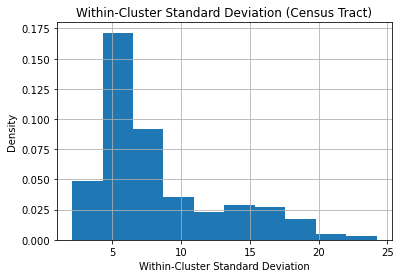

In [24]:
speed_variance_by_tract = speeds_by_tract.aggregate(np.std)["speed_mph_mean"]
speed_variance_by_tract.hist(density = True)
plt.title("Within-Cluster Standard Deviation (Census Tract)")
plt.xlabel("Within-Cluster Standard Deviation")
plt.ylabel("Density")# plot a histogram
average_variance_by_tract = np.mean(speed_variance_by_tract)
variance_average_by_tract = speeds_by_tract.mean()["speed_mph_mean"].std()
average_variance_by_tract, variance_average_by_tract

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q1civ3
points: 3
-->

In [25]:
speed_variance_by_tract

MOVEMENT_ID
9        3.821144
20       5.522853
21       3.640453
44       6.634154
78       3.838873
          ...    
2691     3.379664
2694     5.787065
2695     4.617596
2700    13.191079
2708     7.136608
Name: speed_mph_mean, Length: 295, dtype: float64

In [26]:
grader.check("q1civ3")

q1civ3 results: All test cases passed!

<!-- BEGIN QUESTION -->

## 1.d. What would be the ideal spatial clustering?

This is an active research problem in many spatiotemporal modeling communities, and there is no single agreed-upon answer. Answer both of the following specifically knowing that you'll need to analyze traffic patterns according to this spatial clustering:

1. **What is a good metric for a spatial structure?** How do we define good? Bad? What information do we expect a spatial structure to yield? Use the above parts and questions to help answer this.
2. **What would you do to optimize your own metric for success in a spatial structure?**

See related articles:

- Uber's H3 [link](https://eng.uber.com/h3/), which divides the world into hexagons
- Traffic Analysis Zones (TAZ) [link](https://en.wikipedia.org/wiki/Traffic_analysis_zone), which takes census data and additionally accounts for vehicles per household when dividing space

<!--
BEGIN QUESTION
name: q1d
points: 3
manual: True
-->

A good metric for a spatial structure includes low variability within the cluster compared to the population. Each cluster would have to capture a unique population that would differentiate itself from the population, allowing us to make generalizations and draw conclusions upon the certain cluster. A good metric would also capture this information in a relatively simple manner, such as the hexagons that Uber's H3 uses. In order to optimize my own metric for success in a spatial structure, I would want to create such a clustering that minimizes within cluster variance in relation to across cluster variance. In doing so, the clusters that I define would have some meaningful difference that can correlate to the behavior I am observing. Further, this meaningful difference can then be used to extrapolate behavior through creating a model.

<!-- END QUESTION -->



# Step 2 - Guided EDA: Understanding COVID Lockdown Impact on Traffic

In this step, we'll examine the impact of COVID on traffic. In particular, we'll study 3 different questions:

- How did lockdown affect traffic speed? What factors dictate how much lockdown affected traffic speed?
- What areas of traffic were most impacted by lockdown?

## 2.a. How did lockdown affect traffic speed?

<!-- BEGIN QUESTION -->

### 2.a.i. Sort census tracts by average speed, pre-lockdown.

Consider the pre-lockdown period to be March 1 - 13, before the first COVID-related restrictions (travel bans) were announced on March 14, 2020.

1. **Report a DataFrame which includes the *names* of the 10 census tracts with the lowest average speed**, along with the average speed for each tract.
2. **Report a DataFrame which includes the *names* of the 10 census tracts with the highest average speed**, along with the average speed for each tract.
2. Do these names match your expectations for low speed or high speed traffic pre-lockdown?  What relationships do you notice? (What do the low-speed areas have in common? The high-speed areas?) For this specific question, answer qualitatively. No need to quantify. **Hint**: Look up some of the names on a map, to understand where they are.
3. **Plot a histogram for all average speeds, pre-lockdown**.
4. You will notice a long tail distribution of high speed traffic. What do you think this corresponds to in San Francisco? Write down your hypothesis.

Hint: To start off, think about what joins may be useful to get the desired DataFrame.

<!--
BEGIN QUESTION
name: q2ai1
points: 3
manual: True
-->

These names do match my expectations for low speed or high speed traffic pre-lockdown, as I notice that all of the locations in the 10 lowest average speed areas are in San Francisco. This is to be expected, as San Francisco is a metropolis, which comes with traffic as people move in and out of the city daily for work and play. Further, the locations are clustered around Union Square, which is a tourist attraction and has other attractions, such as shopping malls. For highest average speed areas, the locations are more spread out and are located in smaller cities surrounding San Francisco. They are also typically near nature, such as the ocean or in parks, where less people usually travel. I think the long tail distribution of high speed traffic corresponds to Highways in San Francisco, as there are relatively few of them with higher speed limits.

<!-- END QUESTION -->

Answer the following question:
<!--
BEGIN QUESTION
name: q2ai2
points: 3
-->

In [27]:
# compute the average speed per census tract (will use this later),
# BEFORE the shelter-in-place was announced on March 14, 2020.
# Autograder expects this to be a series
averages_pre = speeds_to_tract[speeds_to_tract["day"] < 14].groupby("MOVEMENT_ID").mean()["speed_mph_mean"]
# Autograder expects this to be a dataframe with name of census tract,
# polygon for census tract, and average speed per census tract
averages_pre_named = speeds_to_tract[speeds_to_tract["day"] < 14].groupby("MOVEMENT_ID").first()[["DISPLAY_NAME", "geometry"]]
averages_pre_named["speed_mph_mean"] = averages_pre
averages_pre_named

,DISPLAY_NAME,geometry,speed_mph_mean
MOVEMENT_ID,,,
9,"500 Hyde Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41827 37.78704, -122.4150...",14.585102
20,"900 Sutter Street, Lower Nob Hill, San Francisco","MULTIPOLYGON (((-122.42208 37.78847, -122.4153...",15.679922
21,"3400 Pierce Street, Marina District, San Franc...","MULTIPOLYGON (((-122.44191 37.80374, -122.4371...",14.292445
44,"1700 Egbert Avenue, Bayview, San Francisco","MULTIPOLYGON (((-122.40211 37.72779, -122.3998...",23.353083
78,"1400 Thomas Avenue, Bayview, San Francisco","MULTIPOLYGON (((-122.39270 37.72928, -122.3918...",16.213552
...,...,...,...
2691,"800 Hacienda Way, Millbrae","MULTIPOLYGON (((-122.42288 37.60714, -122.4187...",20.746333
2694,"1900 Buchanan Street, Western Addition, San Fr...","MULTIPOLYGON (((-122.43549 37.78870, -122.4338...",17.042386
2695,"2200 Rivera Street, Sunset District, San Franc...","MULTIPOLYGON (((-122.49505 37.74968, -122.4858...",20.029011


In [28]:
grader.check("q2ai2")

q2ai2 results: All test cases passed!

Report the lowest 10 census tracts with the lowest average speed
Remember we want the NAME of each census tract too. For the autograder, please keep the name of the speed field, `speed_mph_mean`.

<!--
BEGIN QUESTION
name: q2ai3
points: 1
-->

In [29]:
bottom10_averages_pre = averages_pre_named.sort_values("speed_mph_mean").head(10)
bottom10_averages_pre

,DISPLAY_NAME,geometry,speed_mph_mean
MOVEMENT_ID,,,
1691,"200 O'Farrell Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41462 37.78558, -122.4129...",12.417079
2340,"0 Mason Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41405 37.78279, -122.4107...",12.595120
1688,"1100 Taylor Street, Nob Hill, San Francisco","MULTIPOLYGON (((-122.41629 37.79389, -122.4152...",12.945291
651,"2900 22nd Street, Mission District, San Francisco","MULTIPOLYGON (((-122.41672 37.75717, -122.4123...",13.195865
643,"200 Myrtle Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.42146 37.78663, -122.4182...",13.490311
1689,"200 Sutter Street, Financial District, San Fra...","MULTIPOLYGON (((-122.40879 37.79016, -122.4071...",13.502505
1244,"800 Jackson Street, Chinatown, San Francisco","MULTIPOLYGON (((-122.41172 37.79629, -122.4084...",13.549474
1245,"500 Geary Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41500 37.78745, -122.4133...",13.570625
644,"200 Jones Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41443 37.78466, -122.4127...",13.626251


In [30]:
grader.check("q2ai3")

q2ai3 results: All test cases passed!

Report the highest 10 census tracts with the highest average speed.

<!--
BEGIN QUESTION
name: q2ai4
points: 1
-->

In [31]:
top10_averages_pre = averages_pre_named.sort_values("speed_mph_mean", ascending = False).head(10)
top10_averages_pre

,DISPLAY_NAME,geometry,speed_mph_mean
MOVEMENT_ID,,,
285,"1600 Maritime Street, Oakland","MULTIPOLYGON (((-122.33037 37.82058, -122.3161...",59.498552
495,"4200 Shelter Creek Lane, San Bruno","MULTIPOLYGON (((-122.43101 37.61999, -122.4300...",53.867847
1653,"Petrolite Street, Richmond","MULTIPOLYGON (((-122.42976 37.96540, -122.4185...",47.318340
2339,"Frenchmans Creek Road, Half Moon Bay","MULTIPOLYGON (((-122.46816 37.56079, -122.4605...",47.225137
1744,"1200 Helen Drive, Millbrae","MULTIPOLYGON (((-122.42820 37.60497, -122.4263...",45.492292
2244,"0 Crystal Springs Terrace, Hillsborough Park, ...","MULTIPOLYGON (((-122.37189 37.54776, -122.3710...",44.304919
2660,"0 Burgess Court, Sausalito","MULTIPOLYGON (((-122.52032 37.87046, -122.5193...",43.848188
1955,"Liccicitos Road, Moss Beach","MULTIPOLYGON (((-122.52036 37.57534, -122.5180...",42.784267
1732,"0 Longview Drive, Westlake, Daly City","MULTIPOLYGON (((-122.50053 37.70083, -122.4961...",40.587037


In [32]:
grader.check("q2ai4")

q2ai4 results: All test cases passed!

<!-- BEGIN QUESTION -->

Plot the histogram
<!--
BEGIN QUESTION
name: q2ai5
points: 1
manual: True
-->

Text(0, 0.5, 'Density')

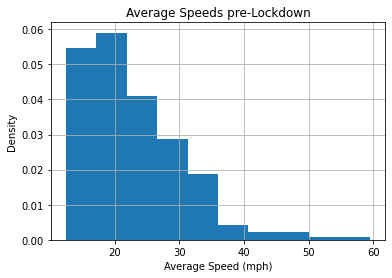

In [33]:
averages_pre.hist(density = True)
plt.title("Average Speeds pre-Lockdown")
plt.xlabel("Average Speed (mph)")
plt.ylabel("Density")

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 2.a.ii. Sort census tracts by average speed, post-lockdown.

I suggest checking the top 10 and bottom 10 tracts by average speed, post-lockdown. Consider the post-lockdown period to be March 14 - 31, after the first COVID restrictions were established on March 14, 2020. It's a healthy sanity check. For this question, you should report:

- **Plot a histogram for all average speeds, post-lockdown.**
- **What are the major differences between this post-lockdown histogram relative to the pre-lockdown histogram above**? Anything surprising? What did you expect, and what did you find?

Write the written answers in the cell below, and the coding answers in the cells after that.

<!--
BEGIN QUESTION
name: q2aii1
points: 1
manual: True
-->

It looks like average speeds have generally increased between this post-lockdown histogram relative to the pre-lockdown histogram. It looks as if the mode of the post-lockdown is 20-30 mph while the pre-lockdown mode was under 20. Further, there is overall more people driving faster, as there is density in the 60-70 range now whereas the pre-lockdown was capped at 60 mph. This increase of speed makes sense, as less cars on the roads due to lockdown decreases traffic dramatically. Thus, people who are on the streets are able to drive faster.

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q2aii2
points: 2
-->

In [34]:
# compute the average speed per census tract (will use this later),
# AFTER (and including) the first COVID restrictions were put into effect.
# Autograder expects this to be a series
averages_post = speeds_to_tract[speeds_to_tract["day"] > 13].groupby("MOVEMENT_ID").mean()["speed_mph_mean"]
# Autograder expects this to be a dataframe with name of census tract,
# polygon for census tract, and average speed per census tract
averages_post_named = speeds_to_tract[speeds_to_tract["day"] > 13].groupby("MOVEMENT_ID").first()[["DISPLAY_NAME", "geometry"]]
averages_post_named["speed_mph_mean"] = averages_post
averages_post_named

,DISPLAY_NAME,geometry,speed_mph_mean
MOVEMENT_ID,,,
9,"500 Hyde Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41827 37.78704, -122.4150...",16.143154
20,"900 Sutter Street, Lower Nob Hill, San Francisco","MULTIPOLYGON (((-122.42208 37.78847, -122.4153...",16.871488
21,"3400 Pierce Street, Marina District, San Franc...","MULTIPOLYGON (((-122.44191 37.80374, -122.4371...",15.754795
44,"1700 Egbert Avenue, Bayview, San Francisco","MULTIPOLYGON (((-122.40211 37.72779, -122.3998...",25.956602
78,"1400 Thomas Avenue, Bayview, San Francisco","MULTIPOLYGON (((-122.39270 37.72928, -122.3918...",16.476000
...,...,...,...
2691,"800 Hacienda Way, Millbrae","MULTIPOLYGON (((-122.42288 37.60714, -122.4187...",17.917000
2694,"1900 Buchanan Street, Western Addition, San Fr...","MULTIPOLYGON (((-122.43549 37.78870, -122.4338...",22.128519
2695,"2200 Rivera Street, Sunset District, San Franc...","MULTIPOLYGON (((-122.49505 37.74968, -122.4858...",23.440404


In [35]:
grader.check("q2aii2")

q2aii2 results: All test cases passed!

<!-- BEGIN QUESTION -->

Plot the histogram
<!--
BEGIN QUESTION
name: q2aii3
points: 1
manual: True
-->

Text(0, 0.5, 'Density')

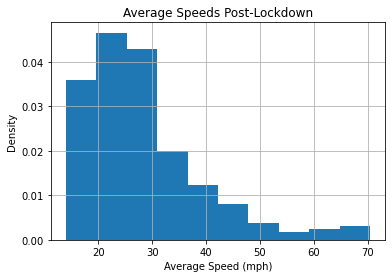

In [36]:
averages_post.hist(density = True)
plt.title("Average Speeds Post-Lockdown")
plt.xlabel("Average Speed (mph)")
plt.ylabel("Density")

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 2.a.iii. Sort census tracts by change in traffic speed from pre to post lockdown.

For each segment, compute the difference between the pre-lockdown average speed (March 1 - 13) and the post-lockdown average speed (March 14 - 31). **Plot a histogram of all differences.** Sanity check that the below histogram matches your observations of the histograms above, on your own.

<!--
BEGIN QUESTION
name: q2aiii
points: 2
manual: True
-->

Text(0, 0.5, 'Density')

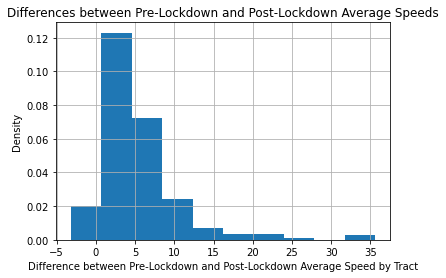

In [37]:
# The autograder expects differences to be a series object with index
# MOVEMENT_ID.
differences = averages_post - averages_pre
# plot the differences

differences.hist(density = True)
plt.title("Differences between Pre-Lockdown and Post-Lockdown Average Speeds")
plt.xlabel("Difference between Pre-Lockdown and Post-Lockdown Average Speed by Tract")
plt.ylabel("Density")

In [38]:
grader.check("q2aiii")

q2aiii results: All test cases passed!

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 2.a.iv. Quantify the impact of lockdown on average speeds.

1. **Plot the average speed by day, across all segments**. Be careful not to plot the average of census tract averages instead. Recall the definition of segments from Q1.
2. Is the change in speed smooth and gradually increasing? Or increasing sharply? Why? Use your real-world knowledge of announcements and measures during that time, in your explanation. You can use this list of bay area COVID-related dataes: https://abc7news.com/timeline-of-coronavirus-us-covid-19-bay-area-sf/6047519/

<!--
BEGIN QUESTION
name: q2aiv1
points: 1
manual: True
-->

Text(0, 0.5, 'Average Speed (mph)')

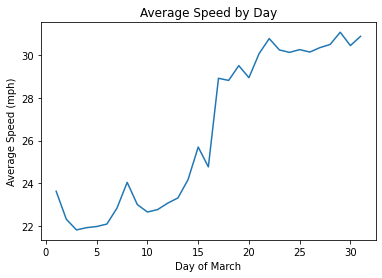

In [39]:
# Autograder expects this to be a series object containing the
# data for your line plot -- average speeds per day.
speeds_daily = speeds_to_tract.groupby("day").mean()["speed_mph_mean"]
speeds_daily.plot()
plt.title("Average Speed by Day")
plt.xlabel("Day of March")
plt.ylabel("Average Speed (mph)")

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Write your written answer in the cell below

<!--
BEGIN QUESTION
name: q2aiv2
points: 1
manual: True
-->

The change in speed is not smooth or gradual, rather it is sudden, with a sharp increase between the 16th and 17th of March. I found this suprising because I thought the increase in speed would correlate with the start of the lockdown on the 14th, however, the increase occurs around 2 days later. However, I now see, from the article, that this is most likely due to the Shelter in Pace order that was announced on March 16th, 2020 for six Bay Area counties, which took effect at midnight, March 17th. This explains the dramatic increase in average speed between 16th and 17th, which is explained by the dramatic decrease in traffic.

<!-- END QUESTION -->

Ignore the empty cell below, just run the autograder to test the code above is correct.
<!--
BEGIN QUESTION
name: q2aiv3
points: 1
-->

In [40]:
grader.check("q2aiv3")

q2aiv3 results: All test cases passed!

<!-- BEGIN QUESTION -->

### 2.a.v. Quantify the impact of pre-lockdown average speed on change in speed.

1. Compute the correlation between change in speed and the *pre*-lockdown average speeds. Do we expect a positive or negative correlation, given our analysis above?
2. Compute the correlation between change in speed and the post-lockdown average speeds.
3. **How does the correlation in Q1 compare with the correlation in Q2?** You should expect a significant change in correlation value. What insight does this provide about traffic?

Written answers in the first cell, coding answerts in the following cell.

<!--
BEGIN QUESTION
name: q2av1
points: 2
manual: True
-->

The correlation increased quite a bit between Q1 and Q2, and we expect a positive correlation for both values based on our analysis. This is because since we are looking at the changes in speeds pre and post lockdown, we expect high values of post lockdown average speeds to be correlated with high values of differences; if the average speed dramatically increased, the difference between the pre and post-lockdown speeds would also increase. This explains the higher correlation coefficient for the relationship between change in speed and the post-lockdown average speeds (as compared to the relationship between change in speed and the pre-lockdown average speeds). In terms of traffic, this shows us that average speeds did increase.

<!-- END QUESTION -->


<!--
BEGIN QUESTION
name: q2av2
points: 2
-->

In [41]:
corr_pre_diff = averages_pre.corr(differences)
corr_post_diff = averages_post.corr(differences)
corr_pre_diff, corr_post_diff

(0.46330063805801847, 0.7926799984780658)

In [42]:
grader.check("q2av2")

q2av2 results: All test cases passed!

## 2.b. What traffic areas were impacted by lockdown?

<!-- BEGIN QUESTION -->

### 2.b.i. Visualize spatial heatmap of average traffic speed per census tract, pre-lockdown.

Visualize a spatial heatmap of the grouped average daily speeds per census tract, which you computed in previous parts. Use the geopandas [chloropleth maps](https://geopandas.org/docs/user_guide/mapping.html#choropleth-maps). **Write your observations, using your visualization, noting down at least 2 areas or patterns of interest**. These may be a local extrema, or a region that is strangely all similar.

**Hint**: Use [`to_crs`](https://geopandas.org/docs/reference/api/geopandas.GeoDataFrame.to_crs.html) and make sure the `epsg` is using the Pseudo-Mercator projection.

**Hint**: You can use `contextily` to superimpose your chloropleth map on a real geographic map.

**Hint** You can set a lower opacity for your chloropleth map, to see what's underneath, but be aware that if you plot with too low of an opacity, the map underneath will perturb your chloropleth and meddle with your conclusions.

Written answers in the first cell, coding answers in the second cell.

<!--
BEGIN QUESTION
name: q2bi1
points: 1
manual: True
-->

Overall average speeds within San Francisco are overall the lowest among the average speeds of census tracts within the bay area, signified by almost the entire city being purple. On the other hand, the surrounding cities generally have higher average speeds, as evidenced by the more greenish hue of these tracts. Further, the large northwestern census tract by Fairfax is interesting in that the entire area has a singular average speed. Another large tract is formed south of San Francisco and has a light green hue. Both of these large areas correspond to parks within the bay area.



<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!--
BEGIN QUESTION
name: q2bi2
points: 4
manual: True
-->

Text(0.5, 1.0, 'Grouped Average Daily Speeds per Census Tract')

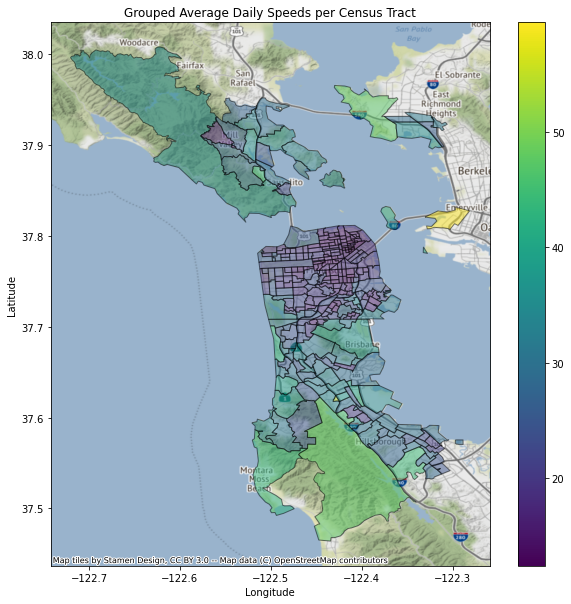

In [43]:
averages_pre_named.set_crs(crs = None, epsg = 3857, inplace = False, allow_override = False)
plot = averages_pre_named.plot(column = "speed_mph_mean", figsize=(10, 10), alpha=0.5, edgecolor='k', legend = True)
cx.add_basemap(plot, crs = averages_pre_named.crs.to_string())
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Grouped Average Daily Speeds per Census Tract")

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 2.b.ii. Visualize change in average daily speeds pre vs. post lockdown.

Visualize a spatial heatmap of the census tract differences in average speeds, that we computed in a previous part. **Write your observations, using your visualization, noting down at least 2 areas or patterns of interest.** Some possible ideas for interesting notes: Which areas saw the most change in average speed? Which areas weren't affected? Why did some areas see *reduced* average speed?

First cell is for the written answers, second cell is for the coding answers.

<!--
BEGIN QUESTION
name: q2bii1
points: 1
manual: True
-->

The greatest difference between pre and post-lockdown average speeds is in two census tracts near Hillsborough (yellow colored). Further, speeds within San Francisco generally did not change much, as most of the city is purple hued. Near Emeryville, although it had the highest average speed in the bay area, this census tract experienced little to no difference pre and post lockdown.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!--
BEGIN QUESTION
name: q2bii2
points: 4
manual: True
-->

Text(0.5, 1.0, 'Census Tract Differences in Average Speeds')

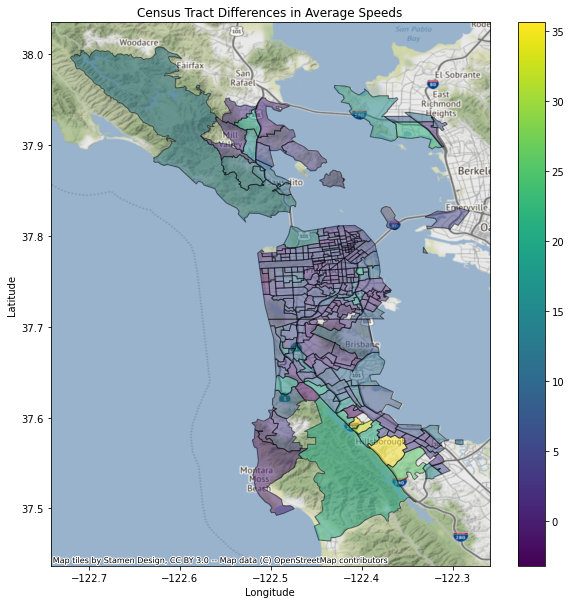

In [44]:
average_diffs = averages_pre_named[["DISPLAY_NAME", "geometry"]].set_crs(crs = None, epsg = 3857, inplace = False, allow_override = False)
average_diffs["differences"] = differences
plot2 = average_diffs.plot(column = "differences", figsize=(10, 10), alpha=0.5, edgecolor='k', legend = True)
cx.add_basemap(plot2, crs = averages_pre_named.crs.to_string())
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Census Tract Differences in Average Speeds")

<!-- END QUESTION -->



# Step 3 - Open-Ended EDA: Understanding lockdown impact on travel times

Explore daily travel times from Hayes Valley to other destinations both before and throughout lockdown. Use the following questions as suggestions for what to explore, temporally and spatially:

- How did lockdown affect travel times? Are there any meaningful factors that determined how travel time would be impacted? How was travel time affected over time?
- Travel to which destinations were affected by lockdown? Are there surprisingly disproportionate amounts of impact in certain areas?

## 3.a. Load Datasets

In this step, we will load two datasets:

- Daily travel times from Hayes Valley to all other census tracts around San Francisco.
- Daily travel times from 300 Hayes St to Golden Gate Park in San Francisco.

For this specific set of data, we can ask several more questions; which questions you pursue are up to you, including any that you come up that are not on this list:

- Which routes from Hayes Valley had similar impact on travel time? Did they share any factors in common? Traveling through the same place -- e.g., a freway? Traveling in similar areas e.g., residential areas?
- Were clusters of routes impacted more severely than others over time? What determined the degree of impact?

In [45]:
PATH_TIMES = 'data/travel-times-daily-san-francisco-2020-3.csv'
times_to_tract = pd.read_csv(PATH_TIMES)
times_to_tract

,Origin Movement ID,Origin Display Name,Destination Movement ID,Destination Display Name,Date Range,Mean Travel Time (Seconds),Range - Lower Bound Travel Time (Seconds),Range - Upper Bound Travel Time (Seconds),day
0,1277,"300 Hayes Street, Civic Center, San Francisco",9,"500 Hyde Street, Tenderloin, San Francisco","3/1/2020 - 3/1/2020, Every day, Daily Average",322,211,489,1
1,1277,"300 Hayes Street, Civic Center, San Francisco",20,"900 Sutter Street, Lower Nob Hill, San Francisco","3/1/2020 - 3/1/2020, Every day, Daily Average",291,179,470,1
2,1277,"300 Hayes Street, Civic Center, San Francisco",21,"3400 Pierce Street, Marina District, San Franc...","3/1/2020 - 3/1/2020, Every day, Daily Average",635,438,920,1
3,1277,"300 Hayes Street, Civic Center, San Francisco",44,"1700 Egbert Avenue, Bayview, San Francisco","3/1/2020 - 3/1/2020, Every day, Daily Average",786,566,1090,1
4,1277,"300 Hayes Street, Civic Center, San Francisco",46,"500 Chester Street, West Oakland, Oakland","3/1/2020 - 3/1/2020, Every day, Daily Average",891,682,1162,1
...,...,...,...,...,...,...,...,...,...
10333,1277,"300 Hayes Street, Civic Center, San Francisco",2624,"1300 16th Avenue, Inner Sunset, San Francisco","3/31/2020 - 3/31/2020, Every day, Daily Average",502,411,611,31
10334,1277,"300 Hayes Street, Civic Center, San Francisco",2643,"1300 Egbert Avenue, Bayview, San Francisco","3/31/2020 - 3/31/2020, Every day, Daily Average",571,475,685,31
10335,1277,"300 Hayes Street, Civic Center, San Francisco",2673,"100 Rutledge Street, Bernal Heights, San Franc...","3/31/2020 - 3/31/2020, Every day, Daily Average",367,265,507,31
10336,1277,"300 Hayes Street, Civic Center, San Francisco",2694,"1900 Buchanan Street, Western Addition, San Fr...","3/31/2020 - 3/31/2020, Every day, Daily Average",222,167,294,31


Text(0, 0.5, 'Mean Travel Time (Seconds)')

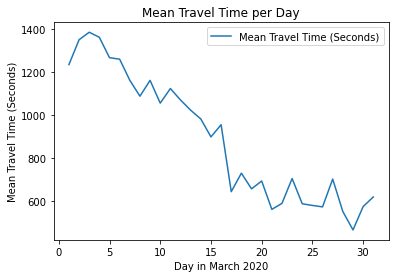

In [46]:
means_per_time = times_to_tract.groupby("day").mean()
means_per_time[["Mean Travel Time (Seconds)"]].plot()
plt.title("Mean Travel Time per Day")
plt.xlabel("Day in March 2020")
plt.ylabel("Mean Travel Time (Seconds)")

In [47]:
weather_to_day = pd.read_csv('data/weather-data.csv')
weather_to_day = weather_to_day.set_index("Date (March 2020)")
weather_to_day.head()

,Precipitation (in.),Wind(mph)
Date (March 2020),,
1,0.0,12.2
2,0.0,14.5
3,0.0,6.5
4,0.0,5.0
5,0.0,6.8


Text(0, 0.5, 'Precipitation (in)')

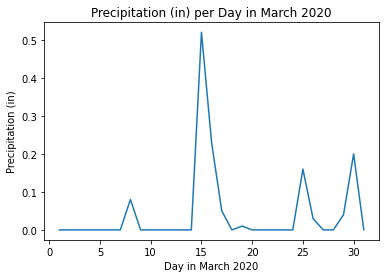

In [48]:
plt.plot(weather_to_day["Precipitation (in.)"])
plt.title("Precipitation (in) per Day in March 2020")
plt.xlabel("Day in March 2020")
plt.ylabel("Precipitation (in)")

Text(0, 0.5, 'Wind Speed (mph)')

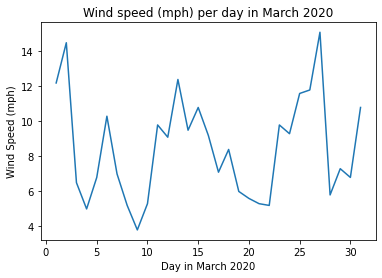

In [49]:
plt.plot(weather_to_day["Wind(mph)"])
plt.title("Wind speed (mph) per day in March 2020")
plt.xlabel("Day in March 2020")
plt.ylabel("Wind Speed (mph)")

In [50]:
pre_mean = times_to_tract[["Destination Movement ID", "Mean Travel Time (Seconds)", "day"]][(times_to_tract["day"] < 14)].groupby("Destination Movement ID").mean()
post_mean = times_to_tract[["Destination Movement ID", "Mean Travel Time (Seconds)", "day"]][times_to_tract["day"] > 13].groupby("Destination Movement ID").mean()
pre_mean.head()

,Mean Travel Time (Seconds),day
Destination Movement ID,,
2,1977.000000,7.0
9,343.615385,7.0
20,319.461538,7.0
21,622.153846,7.0
30,1338.000000,8.0


In [51]:
post_mean.head()

,Mean Travel Time (Seconds),day
Destination Movement ID,,
9,253.777778,22.500000
20,228.888889,22.500000
21,472.200000,21.266667
44,643.083333,22.166667
46,876.444444,22.500000


Text(0, 0.5, 'Density')

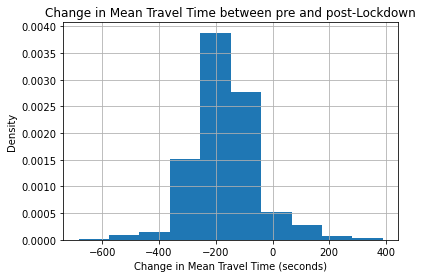

In [52]:
hayes_diff = post_mean.join(pre_mean, rsuffix = "pre", lsuffix = "post")
hayes_diff = hayes_diff.dropna()
mean_diffs = hayes_diff["Mean Travel Time (Seconds)post"] - hayes_diff["Mean Travel Time (Seconds)pre"]
mean_diffs.hist(density = True)
plt.title("Change in Mean Travel Time between pre and post-Lockdown")
plt.xlabel("Change in Mean Travel Time (seconds)")
plt.ylabel("Density")

Text(198.0047479513424, 0.5, 'Latitude')

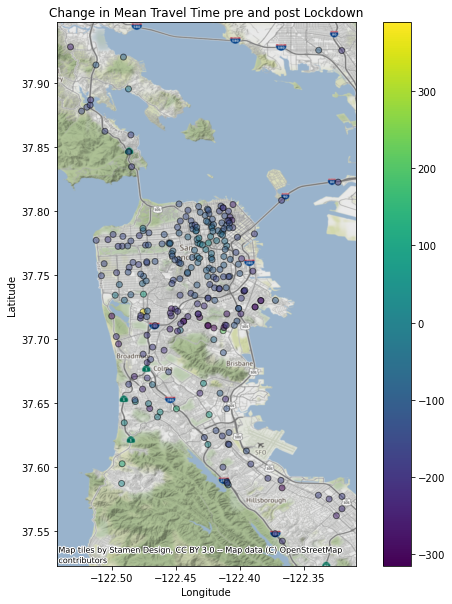

In [53]:
hayes_diff["diff"] = mean_diffs
id_geo = speeds_to_tract[["MOVEMENT_ID", "geometry", "Latitude", "Longitude"]].groupby("MOVEMENT_ID").first()
mean_geo = hayes_diff.join(id_geo).dropna()
geo_mean = gpd.GeoDataFrame(mean_geo, geometry=gpd.points_from_xy(mean_geo.Longitude, mean_geo.Latitude)).set_crs(epsg = 3857)
plot3 = geo_mean.plot(column = "diff", figsize = (10, 10), alpha = 0.5, edgecolor = "k", legend = True)
cx.add_basemap(plot3, crs = averages_pre_named.crs.to_string())
plt.title("Change in Mean Travel Time pre and post Lockdown")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

It appears that the Lockdown had a negative impact on mean travel time, meaning that people generally got to their destinations from 300 Hayes faster after lockdown. Interstingly, we see outliers where it took longer to get to their destination after lockdown. We might want to look into what factors determines the magnitude of change.

In [54]:
geo_mean.head()

,Mean Travel Time (Seconds)post,daypost,Mean Travel Time (Seconds)pre,daypre,diff,geometry,Latitude,Longitude
Destination Movement ID,,,,,,,,
9,253.777778,22.500000,343.615385,7.0,-89.837607,POINT (-122.417 37.784),37.784356,-122.416866
20,228.888889,22.500000,319.461538,7.0,-90.572650,POINT (-122.422 37.788),37.788013,-122.421946
21,472.200000,21.266667,622.153846,7.0,-149.953846,POINT (-122.440 37.800),37.800303,-122.440328
44,643.083333,22.166667,864.846154,7.0,-221.762821,POINT (-122.399 37.719),37.719407,-122.399063
78,755.222222,19.000000,1032.000000,7.0,-276.777778,POINT (-122.388 37.725),37.724729,-122.387930


In [55]:
hayes_lat = id_geo.loc[1277][1]
hayes_long = id_geo.loc[1277][2]
hayes_lat, hayes_long

(37.7748083, -122.4243081)

In [56]:
def distance(x, y, x2, y2):
    return ((x - x2)**2 + (y - y2)**2)**0.5

def distance_from_hayes(x, y):
    return distance(hayes_lat, hayes_long, x, y)

distance_from_hayes(id_geo.loc[9][1], id_geo.loc[9][2])

0.012106056284360806

In [57]:
geo_mean["distance"] = distance_from_hayes(geo_mean["Latitude"], geo_mean["Longitude"])
geo_mean.head()

,Mean Travel Time (Seconds)post,daypost,Mean Travel Time (Seconds)pre,daypre,diff,geometry,Latitude,Longitude,distance
Destination Movement ID,,,,,,,,,
9,253.777778,22.500000,343.615385,7.0,-89.837607,POINT (-122.417 37.784),37.784356,-122.416866,0.012106
20,228.888889,22.500000,319.461538,7.0,-90.572650,POINT (-122.422 37.788),37.788013,-122.421946,0.013415
21,472.200000,21.266667,622.153846,7.0,-149.953846,POINT (-122.440 37.800),37.800303,-122.440328,0.030110
44,643.083333,22.166667,864.846154,7.0,-221.762821,POINT (-122.399 37.719),37.719407,-122.399063,0.060882
78,755.222222,19.000000,1032.000000,7.0,-276.777778,POINT (-122.388 37.725),37.724729,-122.387930,0.061898


In [58]:
distance = geo_mean[["distance"]]
distance.head()

,distance
Destination Movement ID,
9,0.012106
20,0.013415
21,0.030110
44,0.060882
78,0.061898


In [59]:
final_dataset = times_to_tract.join(weather_to_day, on = "day")
final_dataset.head()

,Origin Movement ID,Origin Display Name,Destination Movement ID,Destination Display Name,Date Range,Mean Travel Time (Seconds),Range - Lower Bound Travel Time (Seconds),Range - Upper Bound Travel Time (Seconds),day,Precipitation (in.),Wind(mph)
0,1277,"300 Hayes Street, Civic Center, San Francisco",9,"500 Hyde Street, Tenderloin, San Francisco","3/1/2020 - 3/1/2020, Every day, Daily Average",322,211,489,1,0.0,12.2
1,1277,"300 Hayes Street, Civic Center, San Francisco",20,"900 Sutter Street, Lower Nob Hill, San Francisco","3/1/2020 - 3/1/2020, Every day, Daily Average",291,179,470,1,0.0,12.2
2,1277,"300 Hayes Street, Civic Center, San Francisco",21,"3400 Pierce Street, Marina District, San Franc...","3/1/2020 - 3/1/2020, Every day, Daily Average",635,438,920,1,0.0,12.2
3,1277,"300 Hayes Street, Civic Center, San Francisco",44,"1700 Egbert Avenue, Bayview, San Francisco","3/1/2020 - 3/1/2020, Every day, Daily Average",786,566,1090,1,0.0,12.2
4,1277,"300 Hayes Street, Civic Center, San Francisco",46,"500 Chester Street, West Oakland, Oakland","3/1/2020 - 3/1/2020, Every day, Daily Average",891,682,1162,1,0.0,12.2


In [60]:
final_dataset2 = final_dataset.join(distance, on = "Destination Movement ID")
#final_dataset.dropna().sort_values("Destination Movement ID")

In [61]:
final_dataset2 = final_dataset2.dropna().sort_values("Destination Movement ID")
final_dataset2.head()

,Origin Movement ID,Origin Display Name,Destination Movement ID,Destination Display Name,Date Range,Mean Travel Time (Seconds),Range - Lower Bound Travel Time (Seconds),Range - Upper Bound Travel Time (Seconds),day,Precipitation (in.),Wind(mph),distance
0,1277,"300 Hayes Street, Civic Center, San Francisco",9,"500 Hyde Street, Tenderloin, San Francisco","3/1/2020 - 3/1/2020, Every day, Daily Average",322,211,489,1,0.00,12.2,0.012106
9777,1277,"300 Hayes Street, Civic Center, San Francisco",9,"500 Hyde Street, Tenderloin, San Francisco","3/29/2020 - 3/29/2020, Every day, Daily Average",234,153,356,29,0.04,7.3,0.012106
9571,1277,"300 Hayes Street, Civic Center, San Francisco",9,"500 Hyde Street, Tenderloin, San Francisco","3/28/2020 - 3/28/2020, Every day, Daily Average",300,181,496,28,0.00,5.8,0.012106
9319,1277,"300 Hayes Street, Civic Center, San Francisco",9,"500 Hyde Street, Tenderloin, San Francisco","3/27/2020 - 3/27/2020, Every day, Daily Average",248,165,371,27,0.00,15.1,0.012106
9097,1277,"300 Hayes Street, Civic Center, San Francisco",9,"500 Hyde Street, Tenderloin, San Francisco","3/26/2020 - 3/26/2020, Every day, Daily Average",225,158,318,26,0.03,11.8,0.012106


Text(0, 0.5, 'Mean Travel Time (s)')

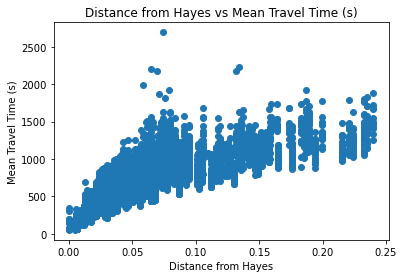

In [62]:
plt.scatter(final_dataset2["distance"], final_dataset2["Mean Travel Time (Seconds)"])
plt.title("Distance from Hayes vs Mean Travel Time (s)")
plt.xlabel("Distance from Hayes")
plt.ylabel("Mean Travel Time (s)")

Text(0, 0.5, 'Mean Travel Time (s)')

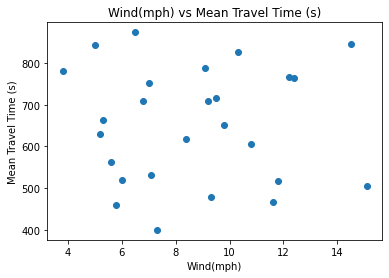

In [63]:
plt.scatter(final_dataset2.groupby("Wind(mph)").mean().reset_index()["Wind(mph)"], final_dataset2.groupby("Wind(mph)").mean()["Mean Travel Time (Seconds)"])
plt.title("Wind(mph) vs Mean Travel Time (s)")
plt.xlabel("Wind(mph)")
plt.ylabel("Mean Travel Time (s)")

Text(0, 0.5, 'Mean Travel Time (s)')

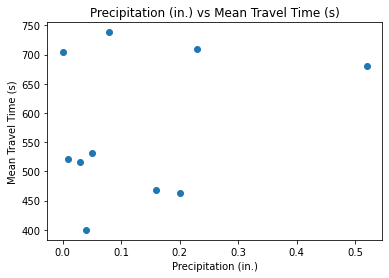

In [64]:
plt.scatter(final_dataset2.groupby("Precipitation (in.)").mean().reset_index()["Precipitation (in.)"], final_dataset2.groupby("Precipitation (in.)").mean()["Mean Travel Time (Seconds)"])
plt.title("Precipitation (in.) vs Mean Travel Time (s)")
plt.xlabel("Precipitation (in.)")
plt.ylabel("Mean Travel Time (s)")

# Step 4 - Guided Modeling: Predict traffic speed post-lockdown

In this step, you'll train a model to predict traffic speed. In particular, you'll learn how to provide implicit supervision and correction to your model, when you know there's been a distribution shift in its data, leading to a large gap between train and test sets. You'll follow the following outline:

- Build a model to predict daily traffic speed in San Francisco. Train and evaluate on *pre*-lockdown traffic speeds around the city.
- Evaluate your model on post-lockdown traffic speeds. Where is your model most mistaken, and why?
- Using this knowledge, how would you correct your model for a more accurate post-lockdown traffic predictor?


The technical term for a phenomenon like the lockdown, which caused major distributional shifts in the data, is *change point*. A large body of work studies "change point detection," but you'll be harder pressed to find a "handling change point" paper. 

## 4.a. Predict daily traffic speed on pre-lockdown data

For your model, you will predict daily traffic speed per census tract, given the previous $k=5$ daily traffic speeds for that census tract. In particular, say a matrix $A$ is $n \times d$, where $n$ is the number of census tracts and $d$ is the number of days. We define the following inputs and labels:

$$X_{(i,t)} = [A_{(i,t-5)}, A_{(i,t-4)}, A_{(i,t-3)}, A_{(i,t-2)}, A_{(i,t-1)}]$$
$$y_{(i,t)} = [A_{(i,t)}]$$

This just means that each sample $X_i$ includes speed averages from the previous 5 days for the $i$th census track.

### 4.a.i. Assemble dataset to predict daily traffic speed.

Below, we've included skeletons for the helper functions we defined, to complete the problem. We highly recommend following this skeleton code, else we cannot guarantee staff support for debugging your work.


**Hint**: What's wrong with collecting all samples, then randomly selecting some percentage to hold out? See the answer in the expandable below.

<details>
    <summary>[Click to expand] How to do train-validation split correctly, on time series</summary>
    
For a *time series* in particular, this random split would be cheating, because data within each day is highly correlated. Instead, you should hold out entire days from the dataset. In this case, you should hold out the last 2 days for your validation set.
</details>

<!--
BEGIN QUESTION
name: q4ai1
points: 1
-->

In [65]:
def dataframe_to_time_series(df: pd.DataFrame):
    """Convert your dataframe into a 'time series'.
    
    :param df: the original dataframe, mapping speeds to census tracts.
        This dataframe should contain the `MOVEMENT_ID` (census tract id),
        `day`, and average speed for that day `speed_mph_mean`
    :return: a new dataframe that is formatted as n x d, where
        n is the number of samples (census tracts) and d is the number of
        dimensions (days). The values are the speeds.
    """
    return pd.pivot_table(df, values = "speed_mph_mean", index = "MOVEMENT_ID", columns = "day")
time_series = dataframe_to_time_series(speeds_to_tract)
time_series_pre = time_series.iloc[:, list(range(13))]

In [66]:
grader.check("q4ai1")

q4ai1 results: All test cases passed!

In [67]:
def time_series_to_numpy(df: pd.DataFrame, T: int, n_val: int):
    """Convert your 'time series' into train-validate splits, in numpy
    
    You can assume your dataframe contains a `day` column where days
    start from 1 and are consecutive.
    
    :param df: the dataframe formatted as n x d, where
        n is the number of samples (census tracts) and d is the number of
        dimensions (days). The values are the speeds.
    :param T: number of days to include in each training sample
    :param n_val: number of days to hold out for the validation set.
        Say we have 5 total days in our dataset, T=2, n_val=2. This means
        during training, we have samples that pull averages from days 1 and
        2 to predict day 3: x=(1, 2), y=(3,) For validation, we have samples
        like x=(2, 3), y=(4,) and x=(3, 4), y=(5,). This way, the model sees
        data from days 4 and 5 only during validation.
    :return: Set of 4 numpy arrays - X_train, y_train, X_val, y_val - where
        X_* arrays are (n, T) and y_* arrays are (n,).
    """
    X_train = []
    y_train = []
    X_val = []
    y_val = []
    
    for ind, r in df.iterrows():
        for i in range(T, len(r) - n_val):
            X_train += [r.iloc[i - T:i].values]
            y_train += [r[i + r.index[0]]]
    
        for j in range(len(r) - n_val, len(r)):
            x = []
            x += list(r.iloc[j - T:j].values)
            X_val += [x]
            y_val += [r[j+r.index[0]]]
        
    return np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val)

def remove_nans(X: np.array, y: np.array):
    """Remove all nans from the provided (X, y) pair.
    
    Note: A nan in X means that sample must be removed from *both X and y.
        Likewise, a nan in y means that sample must be removed from *both
        X and y.
    
    :param X: (n, T) array of model inputs
    :param y: (n,) array of labels
    :return: (X, y)
    """
    if not len(X):
        return X, y
    i = 0
    keepx = []
    keepy = []
    while i < len(X):
        if not np.isnan(X[i]).any() and not np.isnan(y[i]):
            keepx += [X[i]]
            keepy += [y[i]]
        i += 1
            
    return np.array(keepx), np.array(keepy)
answer = time_series_to_numpy(time_series, 10, 2)
answer2 = remove_nans(answer[0], answer[1])

In [68]:
grader.check("q4ai2")

q4ai2 results: All test cases passed!

In [69]:
def time_series_to_dataset(time_series: pd.DataFrame, T: int, n_val: int):
    """Convert 'time series' dataframe to a numpy dataset.
    
    Uses utilites above `time_series_to_numpy` and `remove_nans`
    
    For description of arguments, see `time_series_to_numpy` docstring.
    """
    Xt, yt, Xv, yv = time_series_to_numpy(time_series, T, n_val)
    Xt_clean, yt_clean = remove_nans(Xt, yt)
    Xv_clean, yv_clean = remove_nans(Xv, yv)
    return Xt_clean, yt_clean, Xv_clean, yv_clean
X_train, y_train, X_val, y_val = time_series_to_dataset(time_series_pre, 5, 2)

In [70]:
grader.check("q4ai3")

q4ai3 results: All test cases passed!

In [71]:
time_series

day,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
MOVEMENT_ID,,,,,,,,,,,,,,,,,,,,,
9,16.196918,14.395121,13.868696,14.225414,14.312199,13.811991,15.508637,16.210738,14.845320,14.711534,...,15.880078,17.019573,15.527393,15.925605,15.959744,17.317841,17.845053,17.839214,15.743376,15.797248
20,17.418045,15.460956,15.463297,15.419764,15.291956,15.227310,17.088325,18.088862,16.178105,15.295494,...,18.843376,17.029943,16.286795,17.007889,15.205696,17.461643,16.997424,19.024721,14.134949,17.287814
21,15.141171,13.176998,13.781490,14.052113,14.078134,13.636357,13.958269,14.642295,15.616215,14.850471,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,25.079544,23.492586,22.727711,22.274143,21.874703,23.082414,22.875819,25.653848,23.501387,22.739869,...,24.381933,25.350188,31.126033,NaN,22.518500,27.697570,26.899667,19.777429,24.385409,24.683422
78,16.174464,16.755496,16.039120,16.118401,15.665069,15.797723,15.302616,19.284080,16.253357,16.131290,...,NaN,NaN,15.690000,NaN,NaN,16.849000,NaN,NaN,16.493000,16.767400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2691,NaN,NaN,NaN,NaN,18.600000,17.787000,23.473000,NaN,19.038000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2694,17.809761,16.725889,16.530783,16.446517,16.503053,16.652473,17.427329,18.057287,17.310272,16.998730,...,23.886576,23.410192,23.302396,23.031966,23.107702,23.581885,24.382866,23.278001,23.426889,24.056357
2695,20.106061,20.228850,19.849135,20.145877,22.357605,19.250479,19.223717,19.471282,20.497077,20.401085,...,29.218800,NaN,NaN,NaN,23.396500,NaN,19.708000,26.461900,NaN,19.959500


In [72]:
time_series_pre

day,1,2,3,4,5,6,7,8,9,10,11,12,13
MOVEMENT_ID,,,,,,,,,,,,,
9,16.196918,14.395121,13.868696,14.225414,14.312199,13.811991,15.508637,16.210738,14.845320,14.711534,13.739901,14.391436,13.955833
20,17.418045,15.460956,15.463297,15.419764,15.291956,15.227310,17.088325,18.088862,16.178105,15.295494,14.637109,14.282602,14.437358
21,15.141171,13.176998,13.781490,14.052113,14.078134,13.636357,13.958269,14.642295,15.616215,14.850471,13.790100,14.573349,15.177251
44,25.079544,23.492586,22.727711,22.274143,21.874703,23.082414,22.875819,25.653848,23.501387,22.739869,23.756560,24.989269,23.176275
78,16.174464,16.755496,16.039120,16.118401,15.665069,15.797723,15.302616,19.284080,16.253357,16.131290,15.773117,16.091415,16.208158
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2691,NaN,NaN,NaN,NaN,18.600000,17.787000,23.473000,NaN,19.038000,NaN,NaN,22.107000,NaN
2694,17.809761,16.725889,16.530783,16.446517,16.503053,16.652473,17.427329,18.057287,17.310272,16.998730,16.891788,17.008323,17.559142
2695,20.106061,20.228850,19.849135,20.145877,22.357605,19.250479,19.223717,19.471282,20.497077,20.401085,23.870537,20.215396,20.343131


In [73]:
(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

((1705, 5), (1705,), (562, 5), (562,))

<!-- BEGIN QUESTION -->

### 4.a.ii. Train and evaluate linear model on pre-lockdown data.

1. **Train a linear model that forecasts the next day's speed average** using your training dataset `X_train`, `y_train`. Specifically, predict $y_{(i,t)}$ from $X_{(i,t)}$, where
- $y_{(i,t)}$ is the daily speed average for day $t$ and census tract $i$
- $X_{(i,t)}$ is a vector of daily speed averages for days $t-5,t-4,t-3,t-2,t-1$ for census tract $i$
2. **Evaluate your model** on your validation dataset `X_val`, `y_val`.
3. **Make a scatter plot**, plotting predicted averages against ground truth averages. Note the perfect model would line up all points along the line $y=x$.

Our model is quantitatively and qualitatively pretty accurate at this point, training and evaluating on pre-lockdown data.

<!--
BEGIN QUESTION
name: q4aii1
points: 1
manual: True
-->

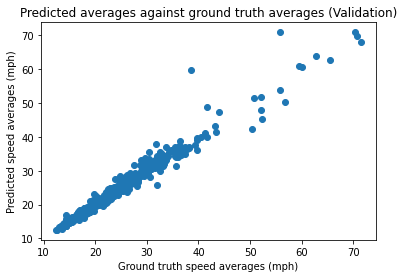

In [74]:
reg = LinearRegression(fit_intercept = True)
reg.fit(X_train, y_train) # set to trained linear model
score = reg.score(X_val, y_val) # report r^2 score
# create the scatter plot below
plt.scatter(y_val, reg.predict(X_val))
plt.title("Predicted averages against ground truth averages (Validation)")
plt.xlabel("Ground truth speed averages (mph)")
plt.ylabel("Predicted speed averages (mph)");

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q4aii2
points: 1
-->

In [75]:
score

0.9639232922122069

In [76]:
grader.check("q4aii2")

q4aii2 results: All test cases passed!

## 4.b. Understand failures on post-lockdown data

Your dataset is distributed spatially and temporally. As a result, the most intuitive spaces to visualize your model error or performance along is both spatially and temporally. In this step, we focus on understanding *where* your model fails.

### 4.b.i. Evaluate on post-lockdown data

1. Using your previously trained linear regression model `reg`, **evaluate on post-lockdown data**, meaning daily speed averages on March 14, 2020. Evaluate on all census tracts.
2. **Make a scatter plot**, plotting predicted averages against ground truth averages. Note the perfect model would line up all points along the line $y=x$.

<!--
BEGIN QUESTION
name: q4bi1
points: 1
-->

In [77]:
time_series_x_pre = time_series.loc[:, [9, 10, 11, 12, 13]] # get 'time series' dataframe for days 8, 10, 11, 12, 13
time_series_y_post = time_series.loc[:, [14]] # get 'time series' dataframe for 14th
X_pre, y_post = remove_nans(time_series_x_pre.to_numpy(), time_series_y_post.to_numpy())
score_pre_14th = reg.score(X_pre, y_post)
score_pre_14th

0.9337122097376678

In [78]:
grader.check("q4bi1")

q4bi1 results: All test cases passed!

In [79]:
time_series_x_pre

day,9,10,11,12,13
MOVEMENT_ID,,,,,
9,14.845320,14.711534,13.739901,14.391436,13.955833
20,16.178105,15.295494,14.637109,14.282602,14.437358
21,15.616215,14.850471,13.790100,14.573349,15.177251
44,23.501387,22.739869,23.756560,24.989269,23.176275
78,16.253357,16.131290,15.773117,16.091415,16.208158
...,...,...,...,...,...
2691,19.038000,NaN,NaN,22.107000,NaN
2694,17.310272,16.998730,16.891788,17.008323,17.559142
2695,20.497077,20.401085,23.870537,20.215396,20.343131


In [80]:
time_series_y_post

day,14
MOVEMENT_ID,
9,15.878056
20,16.095385
21,15.172252
44,25.006452
78,15.128800
...,...
2691,17.917000
2694,17.714930
2695,20.321418


<!-- BEGIN QUESTION -->

Make scatter plot below.
<!--
BEGIN QUESTION
name: q4bi2
points: 1
manual: True
-->

Text(0, 0.5, 'Predicted Average Speed (mph)')

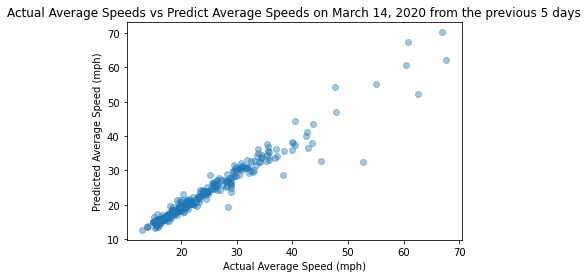

In [81]:
plt.scatter(y_post, reg.predict(X_pre), alpha = 0.4)
plt.title("Actual Average Speeds vs Predict Average Speeds on March 14, 2020 from the previous 5 days")
plt.xlabel("Actual Average Speed (mph)")
plt.ylabel("Predicted Average Speed (mph)")

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 4.b.ii. Report model performance temporally

1. **Make a line plot** showing performance of the original model throughout all of March 2020.
2. **Report the lowest point on the line plot**, reflecting the lowest model performance.
2. **Why is model performance the worst on the 17th?** Why does it begin to worsen on march 15th? And continue to worsen? Use what you know about covid measures on those dates. You may find this webpage useful: https://abc7news.com/timeline-of-coronavirus-us-covid-19-bay-area-sf/6047519/
3. **Is the dip in performance on the 9th foreshadowed** by any of our EDA?
4. **How does the model miraculously recover on its own?**
5. **Make a scatter plot**, plotting predicted averages against ground truth averages *for model predictions on March 17th*. Note the perfect model would line up all points along the line $y=x$. When compared against previous plots of this nature, this plot looks substantially worse, with points straying far from $y=x$.

**Note:** Answer questions 2-5 in the Markdown cell below. Q1 and Q6 are answered in the two code cells below.

<!--
BEGIN QUESTION
name: q4bii1
points: 3
manual: True
-->



2. According to our line plot, the lowest point was on March 17th with a R^2 value of roughly 0.72. The reason why our model worsened starting March 15th was because that was the official date Gavin Newsom, the governor of California, ordered all bars, nightclubs, wineries, and brewpubs to close in California. Because of this, there was definately less cars on the streets, making our prediction of average speeds significantly different from average speeds pre lockdown. 
3. On the 16th, 6 bay-area counties had shelter-in-place orders that would take effect on the 17th, creating disparate average speeds. This is because more people suddenly stayed home due to shelter in place orders, leading to less cars on the street and thus decreased traffic and increased difference in average speeds.
4. No, our group's EDA did not take into account the dip in performance on the 9th of March. However, based on the official COVID-19 timeline, the dip could've been caused by Lake county's declaration of local health emergency.
5. The model seems to recover as the pattern of travel settles down to a new normal state. As March 2020 continued and people got used to the new shelter in place order, driving patterns changed but they settled down as there is still a necessity to travel to "necessary" locations, such as grocery stores.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Generate line plot.
<!--
BEGIN QUESTION
name: q4bii2
points: 1
manual: True
-->

Text(0, 0.5, 'R^2 score of Actual Speed vs Predicted Speeds from Model')

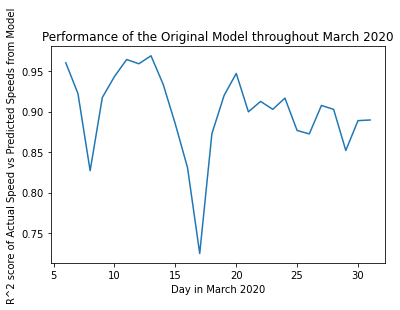

In [82]:
scores = []
for day in range(6, 32):
    X_day = time_series.iloc[:, range(day - 6, day - 1)]
    y_day = time_series.iloc[:, day - 1]
    X_clean, y_clean = remove_nans(X_day.to_numpy(), y_day.to_numpy())
    scores.append(reg.score(X_clean, y_clean))
plt.plot(range(6, 32), scores)
plt.title("Performance of the Original Model throughout March 2020")
plt.xlabel("Day in March 2020")
plt.ylabel("R^2 score of Actual Speed vs Predicted Speeds from Model")

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Generate a scatter plot.
<!--
BEGIN QUESTION
name: q4bii3
points: 1
manual: True
-->

In [83]:
time_series_x_pre17 = time_series.loc[:, [12, 13, 14, 15, 16]] # get 'time series' dataframe for days 8, 10, 11, 12, 13
time_series_y_post17 = time_series.loc[:, [17]] # get 'time series' dataframe for 14th
X_pre17, y_post17 = remove_nans(time_series_x_pre17.to_numpy(), time_series_y_post17.to_numpy())
reg.score(X_pre17, y_post17)

0.7248438392437923

Text(0, 0.5, 'Predicted Average Speeds (mph)')

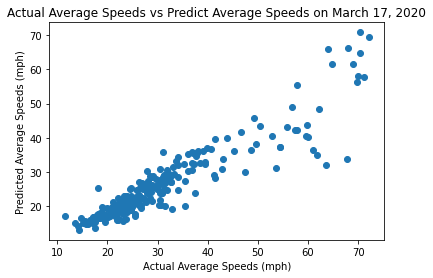

In [84]:
plt.scatter(y_post17, reg.predict(X_pre17))
plt.title("Actual Average Speeds vs Predict Average Speeds on March 17, 2020")
plt.xlabel("Actual Average Speeds (mph)")
plt.ylabel("Predicted Average Speeds (mph)")

<!-- END QUESTION -->



## 4.c. "Fix" model on post-lockdown data

Per this survey https://pure.tue.nl/ws/files/3488790/740215.pdf, there are 4 categories of fixes for change points:
- Forgetting mechanisms
- Explicit change detection
- Ensemble techniques
- Context-aware approaches

In this part, we'll combine insights in model errors with previous EDA insights to produce a fix.

<!-- BEGIN QUESTION -->

### 4.c.i. Learn delta off of a moving bias

According to our previous work in EDA, the average speed shoots upwards sharply. As a result, our trick to learn delta the around the average and to naively assume that the average of day $t$ is the average for day $t+1$. We will do this in 4 steps:

1. **Create a dataset for your delta model**.
2. **Train your delta model** on pre-lockdown data.
3. **Evaluate your model on pre-lockdown data**, to ensure that the model has learned to a satisfactory degree, in the nominal case. Remember the naive model achieved 0.97 r^2 on pre-lockdown data.
4. **Evaluate your model on the 17th**, to compare against the naive model also evaluated on that day. Notice that your r^2 score has improved by 10%+. Why is your delta model so effective for the 17th?
5. **Evaluate your model on the 14th**, to compare against the naive model also evaluated on that day. Notice that your r^2 score is now complete garbage. Why is your delta so ineffective for the 14th?

**Hint**: As you build your datasets, always check to make sure you're using the right days! It's easy to have a one-off error that throws off your results.

Write your written questions in the next cell, then write the code in the following cells.

<!--
BEGIN QUESTION
name: q4ci1
points: 2
manual: True
-->

3. Based on pre-lockdown data, our model achieved an R^2 of .9645. While this R^2 value is good, it is still a bit lower than .97 from the naive model.
4. Our new model had an R^2 of .8346 on the 17th compared with the naive model which had an R^2 of .7248. This is because this new model is trained on the differences between average travel times and not the travel times themselves. Since the 17th experienced a great change due to shelter in place, this model based on changes was able to capture this.

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q4ci2
points: 1
-->

In [85]:
time_series_delta = time_series_pre - speeds_daily[:13]# subtract daily average from pre-lockdown 'time series' dataframe `time_series_pre`
time_series_delta

day,1,2,3,4,5,6,7,8,9,10,11,12,13
MOVEMENT_ID,,,,,,,,,,,,,
9,-7.436210,-7.929735,-7.957726,-7.706332,-7.673488,-8.288859,-7.342673,-7.838718,-8.163539,-7.950124,-9.037052,-8.687048,-9.364599
20,-6.215082,-6.863900,-6.363125,-6.511982,-6.693731,-6.873540,-5.762984,-5.960594,-6.830754,-7.366163,-8.139844,-8.795882,-8.883074
21,-8.491956,-9.147858,-8.044932,-7.879632,-7.907553,-8.464493,-8.893040,-9.407162,-7.392644,-7.811186,-8.986853,-8.505135,-8.143181
44,1.446417,1.167730,0.901289,0.342397,-0.110985,0.981564,0.024509,1.604391,0.492527,0.078211,0.979607,1.910786,-0.144157
78,-7.458664,-5.569360,-5.787301,-5.813345,-6.320619,-6.303126,-7.548693,-4.765377,-6.755502,-6.530367,-7.003837,-6.987069,-7.112274
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2691,NaN,NaN,NaN,NaN,-3.385687,-4.313850,0.621691,NaN,-3.970859,NaN,NaN,-0.971484,NaN
2694,-5.823366,-5.598968,-5.295639,-5.485229,-5.482634,-5.448377,-5.423980,-5.992169,-5.698587,-5.662927,-5.885166,-6.070161,-5.761289
2695,-3.527067,-2.096006,-1.977287,-1.785869,0.371917,-2.850371,-3.627592,-4.578175,-2.511783,-2.260573,1.093583,-2.863087,-2.977301


In [86]:
grader.check("q4ci2")

q4ci2 results: All test cases passed!

In [87]:
X_delta_train, y_delta_train, X_delta_val, y_delta_val = time_series_to_dataset(time_series_delta, 5, 2)
reg_delta = LinearRegression(fit_intercept = True)
reg_delta.fit(X_delta_train, y_delta_train)
res_4ci3 = reg_delta.score(X_delta_val, y_delta_val) # learning delta as easy as learning original dataset!
res_4ci3

0.9645254590172871

In [88]:
grader.check("q4ci3")

q4ci3 results: All test cases passed!

In [89]:
X_17delta = (time_series.iloc[:, [11, 12, 13, 14, 15]] - speeds_daily[11:16]).to_numpy()
y_day17 = (time_series.iloc[:, 16] - speeds_daily[17]).to_numpy()
X_17dc, y_17dc = remove_nans(X_17delta, y_day17)
res_4ci4 = reg_delta.score(X_17dc, y_17dc)
res_4ci4

0.8346539614612525

In [90]:
grader.check("q4ci4")

q4ci4 results:
    q4ci4 - 1 result:
        Trying:
            np.isclose(res_4ci4, 0.8616633417528182, rtol=1e-4, atol=1e-4)
        Expecting:
            True
        **********************************************************************
        Line 1, in q4ci4 0
        Failed example:
            np.isclose(res_4ci4, 0.8616633417528182, rtol=1e-4, atol=1e-4)
        Expected:
            True
        Got:
            False

In [91]:
X_14delta = (time_series.iloc[:, [7, 8, 9, 10, 11]] - speeds_daily[7:12]).to_numpy()
y_day14 = (time_series.loc[:, 14] - speeds_daily[14]).to_numpy()
X_14dc, y_14dc = remove_nans(X_14delta, y_day14)
res_4ci5 = reg_delta.score(X_14dc, y_14dc)
res_4ci5

0.9447158818119351

In [92]:
grader.check("q4ci5")

q4ci5 results:
    q4ci5 - 1 result:
        Trying:
            np.isclose(res_4ci5, 0.11611253470677951, rtol=1e-4, atol=1e-4)
        Expecting:
            True
        **********************************************************************
        Line 1, in q4ci5 0
        Failed example:
            np.isclose(res_4ci5, 0.11611253470677951, rtol=1e-4, atol=1e-4)
        Expected:
            True
        Got:
            False

### 4.c.ii. Does it "solve itself"? Does the pre-lockdown model predict, after the change point?

Had we ignored the problem, would we have been okay? The temporal plot above showing performance over time suggests a partial recovery. **Evaluate the original, naive model on all post-lockdown data** to see. If your final r^2 score does not match the autograder's:
- Double check you have selected daily average speeds for the right days, by printing your dataframe.
- Double check you're using the right model (a brand new trained model)
- Check you're using `T=5, n_val=2`

<!--
BEGIN QUESTION
name: q4cii
points: 1
-->

In [93]:
X_tpost, y_tpost, a, b = time_series_to_dataset(time_series.iloc[:, range(13, 31)], 5, 0)
score_og_post = reg.score(X_tpost, y_tpost)
score_og_post

0.9014738674628208

In [94]:
grader.check("q4cii")

q4cii results: All test cases passed!

### 4.c.iii. Naively retrain model with post-lockdown data

Can we use the same tactics--that we used to train the original model on pre-lockdown data--to train on the post-lockdown data? **Retrain a linear model and evaluate on post-lockdown data only**. You should construct a new dataset using `time_series_to_dataset` using only time series from March 14 to March 31. If your final r^2 score does not match the autograder's:
- Double check you have selected daily average speeds for the right days, by printing your dataframe.
- Double check you're using the right model (a brand new trained model)
- Check you're using `T=5, n_val=2`

<!--
BEGIN QUESTION
name: q4ciii
points: 1
-->

In [95]:
X_tpost2, y_tpost2, X_vpost, y_vpost = time_series_to_dataset(time_series.iloc[:, range(13, 31)], 5, 2)
reg_post = LinearRegression(fit_intercept = True)
reg_post.fit(X_tpost2, y_tpost2)
score_post = reg_post.score(X_vpost, y_vpost)
score_post

0.8993687576351702

In [96]:
grader.check("q4ciii")

q4ciii results: All test cases passed!

### 4.c.iv. What if you just ignore the change point?

Turns out, this is no good. Even acknowledging the change point and training *either* before *or* after is better. Being ignorant and training on *both* is the worst option, producing a lower r^2.

<!--
BEGIN QUESTION
name: q4civ
points: 1
-->

In [97]:
X_tall, y_tall, X_vall, y_vall = time_series_to_dataset(time_series, 5, 5)
reg_all = LinearRegression(fit_intercept = True)
reg_all.fit(X_tall, y_tall)
res_4civ = reg_all.score(X_vall, y_vall)
res_4civ

0.8843433608623494

In [98]:
grader.check("q4civ")

q4civ results: All test cases passed!

# Step 5 - Open-Ended Modeling: Predicting travel time post-lockdown

*This* is the real deal and ultimately what Uber cares about. Traffic speeds is a proxy task, but the bottom line and moneymaking machine relies on this travel time estimation. Focus on designing experiments instead of focusing on experimental, quantitative results. Your experiments are successful if they inform a decision, even despite a lower-performing model.

## Question 5a

Train a baseline model of your choice using any supervised learning approach we have studied; you are not limited to a linear model.


**Example**

Given the data for this question, you could build a model to predict travel time from Cheesecake Factory to UC Berkeley.

In [99]:
final_dataset2.head()

,Origin Movement ID,Origin Display Name,Destination Movement ID,Destination Display Name,Date Range,Mean Travel Time (Seconds),Range - Lower Bound Travel Time (Seconds),Range - Upper Bound Travel Time (Seconds),day,Precipitation (in.),Wind(mph),distance
0,1277,"300 Hayes Street, Civic Center, San Francisco",9,"500 Hyde Street, Tenderloin, San Francisco","3/1/2020 - 3/1/2020, Every day, Daily Average",322,211,489,1,0.00,12.2,0.012106
9777,1277,"300 Hayes Street, Civic Center, San Francisco",9,"500 Hyde Street, Tenderloin, San Francisco","3/29/2020 - 3/29/2020, Every day, Daily Average",234,153,356,29,0.04,7.3,0.012106
9571,1277,"300 Hayes Street, Civic Center, San Francisco",9,"500 Hyde Street, Tenderloin, San Francisco","3/28/2020 - 3/28/2020, Every day, Daily Average",300,181,496,28,0.00,5.8,0.012106
9319,1277,"300 Hayes Street, Civic Center, San Francisco",9,"500 Hyde Street, Tenderloin, San Francisco","3/27/2020 - 3/27/2020, Every day, Daily Average",248,165,371,27,0.00,15.1,0.012106
9097,1277,"300 Hayes Street, Civic Center, San Francisco",9,"500 Hyde Street, Tenderloin, San Francisco","3/26/2020 - 3/26/2020, Every day, Daily Average",225,158,318,26,0.03,11.8,0.012106


In [100]:
from sklearn.model_selection import train_test_split
np.random.seed(47)
X = final_dataset2[["distance"]]
Y = pd.Series(final_dataset2["Mean Travel Time (Seconds)"])

X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X, Y, test_size = 0.1)

In [101]:
m1 = LinearRegression(fit_intercept = True)
m1.fit(X_train1, Y_train1)
m1.score(X_test1, Y_test1)

0.6691395140301477

Text(0, 0.5, 'm1 Predicted Mean Travel Times (s)')

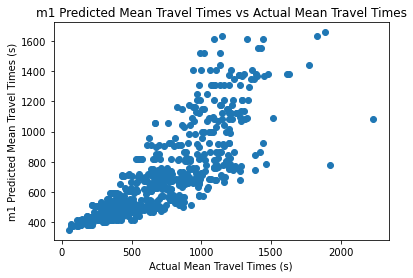

In [102]:
m1_fitted = m1.predict(X_train1)
m1_predicted = m1.predict(X_test1)
plt.scatter(Y_test1, m1_predicted)
plt.title("m1 Predicted Mean Travel Times vs Actual Mean Travel Times")
plt.xlabel("Actual Mean Travel Times (s)")
plt.ylabel("m1 Predicted Mean Travel Times (s)")

Text(0, 0.5, 'Residuals')

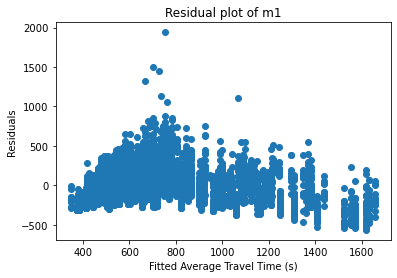

In [103]:
plt.scatter(m1_fitted, Y_train1 - m1_fitted)
plt.title("Residual plot of m1")
plt.xlabel("Fitted Average Travel Time (s)")
plt.ylabel("Residuals")

In [104]:
def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values
    Input:
      predicted (1D array): vector of predicted/fitted values
      actual (1D array): vector of actual values
    Output:
      a float, the root-mean square error
    """
    return np.sqrt(np.mean((actual - predicted)**2))

In [105]:
print("1st Model: m1")
print("Training RMSE: {}".format(rmse(m1_fitted,Y_train1)))
print("Training R^2: {}".format(m1.score(X_train1, Y_train1)))
print("Testing RMSE: {}".format(rmse(m1_predicted,Y_test1)))
print("Testing R^2: {}".format(m1.score(X_test1, Y_test1)))

1st Model: m1
Training RMSE: 207.04940195716287
Training R^2: 0.6420500191502417
Testing RMSE: 208.08452037608222
Testing R^2: 0.6691395140301477


In [106]:
print("Regression coefs")
print("Distance: {}".format(m1.coef_[0]))

Regression coefs
Distance: 5465.212819237182


## Question 5b

Improve on your baseline model. Specify the model you designed and its input features. Justify why you chose these features and their relevance to your model's predictions.

**Example**

Here are potential questions to consider for this part: How does the other variant of your travel times dataset, aggregated across time but reported for all routes, useful?  What additional data from the Uber Movement website can you export to better your model?

In [107]:
final_dataset2.head(2)

,Origin Movement ID,Origin Display Name,Destination Movement ID,Destination Display Name,Date Range,Mean Travel Time (Seconds),Range - Lower Bound Travel Time (Seconds),Range - Upper Bound Travel Time (Seconds),day,Precipitation (in.),Wind(mph),distance
0,1277,"300 Hayes Street, Civic Center, San Francisco",9,"500 Hyde Street, Tenderloin, San Francisco","3/1/2020 - 3/1/2020, Every day, Daily Average",322,211,489,1,0.00,12.2,0.012106
9777,1277,"300 Hayes Street, Civic Center, San Francisco",9,"500 Hyde Street, Tenderloin, San Francisco","3/29/2020 - 3/29/2020, Every day, Daily Average",234,153,356,29,0.04,7.3,0.012106


In [108]:
def is_weekend(day):
    """Return a 1 if the day is weekend and 0 if weekday in March 2020"""
    weekend = [1, 8, 15, 22, 29, 7, 14, 21, 28]
    if day in weekend:
        return 1
    return 0
is_weekend(10)

0

In [109]:
final_dataset2["weekend"] = final_dataset2["day"].apply(is_weekend)
final_dataset2.head(2)

,Origin Movement ID,Origin Display Name,Destination Movement ID,Destination Display Name,Date Range,Mean Travel Time (Seconds),Range - Lower Bound Travel Time (Seconds),Range - Upper Bound Travel Time (Seconds),day,Precipitation (in.),Wind(mph),distance,weekend
0,1277,"300 Hayes Street, Civic Center, San Francisco",9,"500 Hyde Street, Tenderloin, San Francisco","3/1/2020 - 3/1/2020, Every day, Daily Average",322,211,489,1,0.00,12.2,0.012106,1
9777,1277,"300 Hayes Street, Civic Center, San Francisco",9,"500 Hyde Street, Tenderloin, San Francisco","3/29/2020 - 3/29/2020, Every day, Daily Average",234,153,356,29,0.04,7.3,0.012106,1


Text(0, 0.5, 'Average Travel Time (s)')

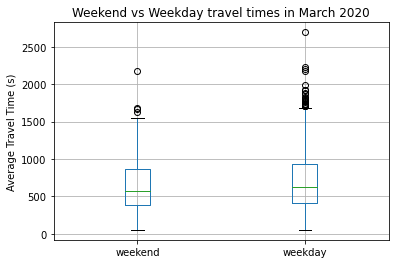

In [110]:
end = final_dataset2[final_dataset2["weekend"] == 1]["Mean Travel Time (Seconds)"]
day = final_dataset2[final_dataset2["weekend"] == 0]["Mean Travel Time (Seconds)"]
weekdays = {"weekend": end.dropna(), "weekday":day.dropna()}
by_day = pd.DataFrame(weekdays)
by_day.boxplot(["weekend", "weekday"])
plt.title("Weekend vs Weekday travel times in March 2020")
plt.ylabel("Average Travel Time (s)")

In [111]:
X2 = final_dataset2[["distance", "Wind(mph)", "Precipitation (in.)", "weekend"]]
Y2 = pd.Series(final_dataset2["Mean Travel Time (Seconds)"])

X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, Y2, test_size = 0.1)

In [112]:
m2 = LinearRegression(fit_intercept = True)
m2.fit(X_train2, Y_train2)
m2.score(X_test2, Y_test2)

0.6750291571314246

Text(0, 0.5, 'm2 Predicted Mean Travel Times (s)')

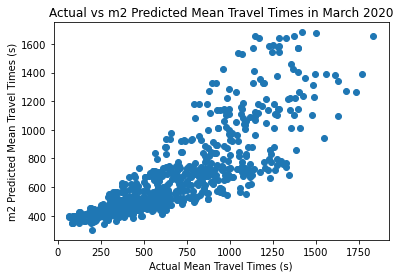

In [113]:
m2_fitted = m2.predict(X_train2)
m2_predicted = m2.predict(X_test2)
plt.scatter(Y_test2, m2_predicted)
plt.title("Actual vs m2 Predicted Mean Travel Times in March 2020")
plt.xlabel("Actual Mean Travel Times (s)")
plt.ylabel("m2 Predicted Mean Travel Times (s)")

Text(0, 0.5, 'Residuals')

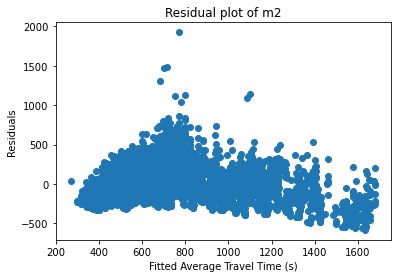

In [114]:
plt.scatter(m2_fitted, Y_train2 - m2_fitted)
plt.title("Residual plot of m2")
plt.xlabel("Fitted Average Travel Time (s)")
plt.ylabel("Residuals")

In [115]:
print("2nd Model: m2")
print("Training RMSE: {}".format(rmse(m2_fitted,Y_train2)))
print("Training R^2: {}".format(m2.score(X_train2, Y_train2)))
print("Testing RMSE: {}".format(rmse(m2_predicted,Y_test2)))
print("Testing R^2: {}".format(m2.score(X_test2, Y_test2)))

2nd Model: m2
Training RMSE: 205.9620209195063
Training R^2: 0.6466568849238064
Testing RMSE: 204.13157374746288
Testing R^2: 0.6750291571314246


In [116]:
print("Regression coefs for m2:")
print("Distance: {}".format(m2.coef_[0]))
print("Wind(mph): {}".format(m2.coef_[1]))
print("Precipitation (in.): {}".format(m2.coef_[2]))
print("weekend/weekday: {}".format(m2.coef_[3]))

Regression coefs for m2:
Distance: 5487.493244427379
Wind(mph): -0.53540146031402
Precipitation (in.): -89.44236055585
weekend/weekday: -44.53763611132128


In [117]:
change = 0.6843283616880405 - 0.6691395140301477
change

0.015188847657892746

Adding Weekday/Weekend split, wind(mph) and precipitation improved our Model's R^2 by 0.015. 

What if we use the past 5 days' Mean Travel Time to predict a day's Mean Travel Time?

In [118]:
time_series_travel = pd.pivot_table(final_dataset2, values = "Mean Travel Time (Seconds)", index = "Destination Movement ID", columns = "day")
time_series_travel.head()

day,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
Destination Movement ID,,,,,,,,,,,,,,,,,,,,,
9,322.0,355.0,369.0,369.0,376.0,374.0,312.0,284.0,345.0,344.0,...,244.0,271.0,331.0,212.0,225.0,248.0,300.0,234.0,237.0,234.0
20,291.0,318.0,327.0,342.0,359.0,354.0,283.0,254.0,310.0,318.0,...,211.0,236.0,253.0,197.0,223.0,240.0,200.0,189.0,296.0,227.0
21,635.0,597.0,723.0,641.0,633.0,641.0,600.0,552.0,610.0,640.0,...,436.0,442.0,488.0,402.0,NaN,461.0,429.0,NaN,517.0,NaN
44,786.0,938.0,1032.0,798.0,1109.0,822.0,787.0,702.0,831.0,835.0,...,533.0,592.0,591.0,529.0,NaN,NaN,587.0,579.0,NaN,805.0
78,789.0,1043.0,1504.0,936.0,1421.0,1029.0,808.0,831.0,960.0,1123.0,...,667.0,751.0,662.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [119]:
X_train3, Y_train3, X_test3, Y_test3 = time_series_to_dataset(time_series_travel, 5, 2)
m3 = LinearRegression(fit_intercept = True)
m3.fit(X_train3, Y_train3)
m3_fitted = m3.predict(X_train3)
m3_predicted = m3.predict(X_test3)

In [120]:
print("3rd Model: m3")
print("Training RMSE: {}".format(rmse(m3_fitted,Y_train3)))
print("Training R^2: {}".format(m3.score(X_train3, Y_train3)))
print("Testing RMSE: {}".format(rmse(m3_predicted,Y_test3)))
print("Testing R^2: {}".format(m3.score(X_test3, Y_test3)))

3rd Model: m3
Training RMSE: 75.52376307962562
Training R^2: 0.9457972262958854
Testing RMSE: 62.80444487864398
Testing R^2: 0.8925406038216579


In [121]:
print("Regression coefs for m3:")
print("Mean of past 5 days' travel times: {}".format(m3.coef_[0]))

Regression coefs for m3:
Mean of past 5 days' travel times: 0.13782883062883225


In [122]:
final_dataset3 = final_dataset2[(final_dataset2["day"] > 5) & (final_dataset2["day"] < 32)]
final_dataset3.sort_values("day").head()

,Origin Movement ID,Origin Display Name,Destination Movement ID,Destination Display Name,Date Range,Mean Travel Time (Seconds),Range - Lower Bound Travel Time (Seconds),Range - Upper Bound Travel Time (Seconds),day,Precipitation (in.),Wind(mph),distance,weekend
2719,1277,"300 Hayes Street, Civic Center, San Francisco",2315,"0 Duboce Avenue, South of Market, San Francisco","3/6/2020 - 3/6/2020, Every day, Daily Average",206,122,346,6,0.0,10.3,0.008573,0
2531,1277,"300 Hayes Street, Civic Center, San Francisco",1119,"0 Locust Avenue, Larkspur","3/6/2020 - 3/6/2020, Every day, Daily Average",1560,1362,1785,6,0.0,10.3,0.187204,0
2609,1277,"300 Hayes Street, Civic Center, San Francisco",1629,"500 Peru Avenue, Excelsior, San Francisco","3/6/2020 - 3/6/2020, Every day, Daily Average",835,619,1124,6,0.0,10.3,0.049401,0
2336,1277,"300 Hayes Street, Civic Center, San Francisco",82,"2700 25th Street, Mission District, San Francisco","3/6/2020 - 3/6/2020, Every day, Daily Average",438,310,617,6,0.0,10.3,0.030925,0
2442,1277,"300 Hayes Street, Civic Center, San Francisco",652,"300 Hale Street, Excelsior, San Francisco","3/6/2020 - 3/6/2020, Every day, Daily Average",517,375,712,6,0.0,10.3,0.045181,0


In [123]:
final_dataset2_grouped = final_dataset2.groupby(["Destination Movement ID", "day"]).first()
final_dataset3_grouped = final_dataset3.groupby(["Destination Movement ID", "day"]).first()

In [124]:
past_days = []
for idday, row in final_dataset3_grouped.iterrows():
    times = []
    for i in list(range(5))[::-1]:
        try:
            times.append(final_dataset2_grouped.loc[(idday[0], idday[1] - (i + 1))]["Mean Travel Time (Seconds)"])
        except:
            times.append(float("NaN"))
    past_days += [np.mean(times)]

In [125]:
final_dataset3_grouped["pastdays"] = np.array(past_days)
final = final_dataset3_grouped.dropna()

In [126]:
X4 = final[["distance", "Wind(mph)", "Precipitation (in.)", "weekend", "pastdays"]]
Y4 = pd.Series(final["Mean Travel Time (Seconds)"])

X_train4, X_test4, Y_train4, Y_test4 = train_test_split(X4, Y4, test_size = 0.1)

In [127]:
m4 = LinearRegression(fit_intercept = True)
m4.fit(X_train4, Y_train4)
m4.score(X_test4, Y_test4)

0.9535095246782693

In [128]:
m4.score(X_train4, Y_train4)

0.9499239477365867

Text(0, 0.5, 'm4 Predicted Mean Travel Time (s)')

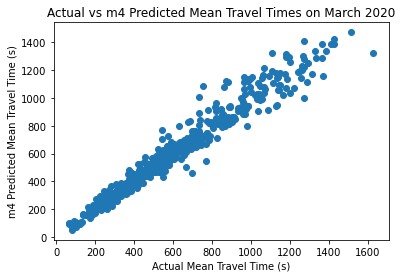

In [129]:
m4_fitted = m4.predict(X_train4)
m4_predicted = m4.predict(X_test4)
plt.scatter(Y_test4, m4_predicted)
plt.title("Actual vs m4 Predicted Mean Travel Times on March 2020")
plt.xlabel("Actual Mean Travel Time (s)")
plt.ylabel("m4 Predicted Mean Travel Time (s)")

Text(0, 0.5, 'Residuals')

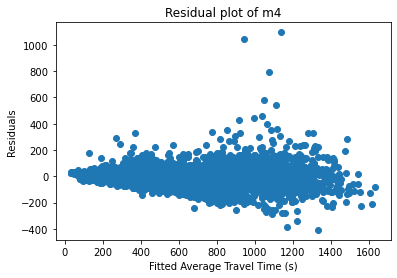

In [130]:
plt.scatter(m4_fitted, Y_train4 - m4_fitted)
plt.title("Residual plot of m4")
plt.xlabel("Fitted Average Travel Time (s)")
plt.ylabel("Residuals")

In [131]:
print("4th Model: m4")
print("Training RMSE: {}".format(rmse(m4_fitted,Y_train4)))
print("Training R^2: {}".format(m4.score(X_train4, Y_train4)))
print("Testing RMSE: {}".format(rmse(m4_predicted,Y_test4)))
print("Testing R^2: {}".format(m4.score(X_test4, Y_test4)))

4th Model: m4
Training RMSE: 72.2370938580992
Training R^2: 0.9499239477365867
Testing RMSE: 67.98543111588364
Testing R^2: 0.9535095246782693


In [132]:
print("Regression coefs for m4:")
print("Distance: {}".format(m4.coef_[0]))
print("Wind(mph): {}".format(m4.coef_[1]))
print("Precipitation (in.): {}".format(m4.coef_[2]))
print("weekend/weekday: {}".format(m4.coef_[3]))
print("Mean of past 5 days' travel times: {}".format(m4.coef_[4]))

Regression coefs for m4:
Distance: 209.85532408300452
Wind(mph): 2.100116554139738
Precipitation (in.): -32.84294458171163
weekend/weekday: -42.92933586170468
Mean of past 5 days' travel times: 0.9309523804376425


Text(0, 0.5, 'Fitted Average Travel Time (s)')

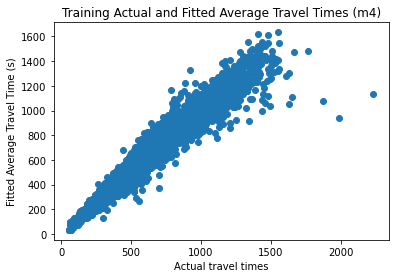

In [133]:
plt.scatter(Y_train4, m4_fitted)
plt.title("Training Actual and Fitted Average Travel Times (m4)")
plt.xlabel("Actual travel times")
plt.ylabel("Fitted Average Travel Time (s)")

In [134]:
Y_train4.sort_values(ascending = False).head(3)

Destination Movement ID  day
2700                     18     2234
653                      12     1990
2463                     18     1872
Name: Mean Travel Time (Seconds), dtype: int64

Three outliers are identified:

    1. 2700 Destination Id, day 18, average travel time 2234
    2. 653                ,     12,                     1990
    3. 2463               ,     18,                     1872

In [135]:
removed_outliers = final[final["Mean Travel Time (Seconds)"] < 1800]

Xfinal = removed_outliers[["distance", "Wind(mph)", "Precipitation (in.)", "weekend", "pastdays"]]
Yfinal = pd.Series(removed_outliers["Mean Travel Time (Seconds)"])

X_trainf, X_testf, Y_trainf, Y_testf = train_test_split(Xfinal, Yfinal, test_size = 0.1)

In [136]:
final_model = LinearRegression(fit_intercept = True)
final_model.fit(X_trainf, Y_trainf)
final_fitted = final_model.predict(X_trainf)
final_predicted = final_model.predict(X_testf)

Text(0, 0.5, 'Final Model Predicted Mean Travel Time (s)')

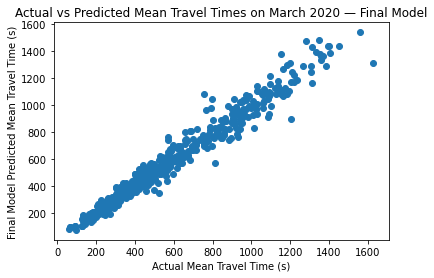

In [137]:
plt.scatter(Y_testf, final_predicted)
plt.title("Actual vs Predicted Mean Travel Times on March 2020 — Final Model")
plt.xlabel("Actual Mean Travel Time (s)")
plt.ylabel("Final Model Predicted Mean Travel Time (s)")

Text(0, 0.5, 'Residuals')

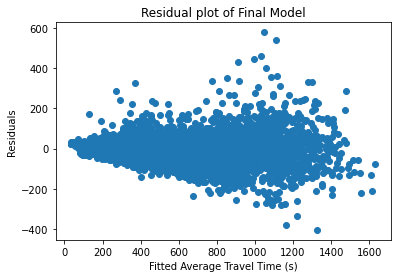

In [138]:
plt.scatter(final_fitted, Y_trainf - final_fitted)
plt.title("Residual plot of Final Model")
plt.xlabel("Fitted Average Travel Time (s)")
plt.ylabel("Residuals")

In [139]:
print("Final Model")
print("Training RMSE: {}".format(rmse(final_fitted,Y_trainf)))
print("Training R^2: {}".format(final_model.score(X_trainf, Y_trainf)))
print("Testing RMSE: {}".format(rmse(final_predicted,Y_testf)))
print("Testing R^2: {}".format(final_model.score(X_testf, Y_testf)))

Final Model
Training RMSE: 68.14103032068806
Training R^2: 0.9546071487294664
Testing RMSE: 62.76077295601918
Testing R^2: 0.962405047822338


In [140]:
print("Regression coefs for Final Model:")
print("Distance: {}".format(final_model.coef_[0]))
print("Wind(mph): {}".format(final_model.coef_[1]))
print("Precipitation (in.): {}".format(final_model.coef_[2]))
print("weekend/weekday: {}".format(final_model.coef_[3]))
print("Mean of past 5 days' travel times: {}".format(final_model.coef_[4]))

Regression coefs for Final Model:
Distance: 232.23969118559955
Wind(mph): 2.313597381483818
Precipitation (in.): -28.618404229041623
weekend/weekday: -41.85841399772928
Mean of past 5 days' travel times: 0.925546562884922


## Question 5c

Explore other modeling aspects and/or temporal information. You are free to relate this to your hypothesis or not. Please expand into multiple parts that logically separate and break down your modeling work!

**Example**

For example, explore change across time, before and after the lockdown: (a) train and evaluate on *pre*-lockdown traffic travel times for that route; and (b) evaluate your model on *post*-lockdown traffic patterns.
How would you correct your model for a more accurate post-lockdown traffic predictor? *The above is just a suggestion. You may pick any topic you find interesting.*

In [141]:
final_preindexed = removed_outliers.reset_index()
pre_lockdown = final_preindexed[final_preindexed["day"] < 14]
post_lockdown = final_preindexed[final_preindexed["day"] > 13]

In [142]:
m5 = LinearRegression(fit_intercept = True)

X_prelock = pre_lockdown[["distance", "Wind(mph)", "Precipitation (in.)", "weekend", "pastdays"]]
Y_prelock = pd.Series(pre_lockdown["Mean Travel Time (Seconds)"])
X_postlock = post_lockdown[["distance", "Wind(mph)", "Precipitation (in.)", "weekend", "pastdays"]]
Y_postlock = pd.Series(post_lockdown["Mean Travel Time (Seconds)"])
m5.fit(X_prelock, Y_prelock)
m5_fitted = m5.predict(X_prelock)
m5_predicted = m5.predict(X_postlock)

Text(0, 0.5, 'm5 Predicted Mean Travel Time (s)')

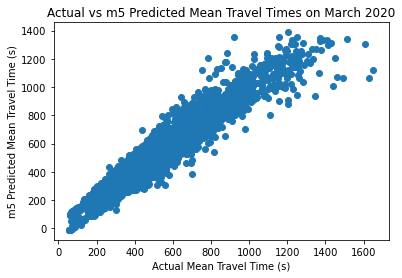

In [143]:
plt.scatter(Y_postlock, m5_predicted)
plt.title("Actual vs m5 Predicted Mean Travel Times on March 2020")
plt.xlabel("Actual Mean Travel Time (s)")
plt.ylabel("m5 Predicted Mean Travel Time (s)")

Text(0, 0.5, 'Residuals')

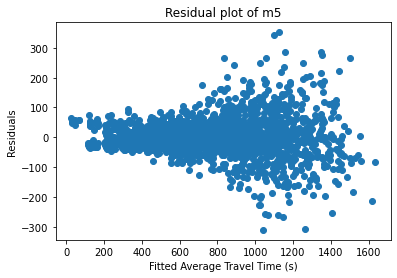

In [144]:
plt.scatter(m5_fitted, Y_prelock - m5_fitted)
plt.title("Residual plot of m5")
plt.xlabel("Fitted Average Travel Time (s)")
plt.ylabel("Residuals")

Text(0, 0.5, 'R^2 score of Actual Speed vs Predicted Speeds from Model')

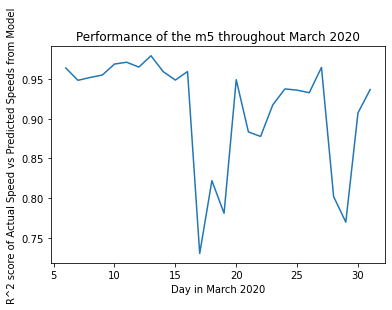

In [145]:
scores5 = []
days = []
for day in range(6, 32):
    thisday = final_preindexed[final_preindexed["day"] == day]
    X_day = thisday[["distance", "Wind(mph)", "Precipitation (in.)", "weekend", "pastdays"]]
    y_day = pd.Series(thisday["Mean Travel Time (Seconds)"])
    try: 
        scores5.append(m5.score(X_day, y_day))
        days.append(day)
    except:
        pass
plt.plot(days, scores5)
plt.title("Performance of the m5 throughout March 2020")
plt.xlabel("Day in March 2020")
plt.ylabel("R^2 score of Actual Speed vs Predicted Speeds from Model")

In [146]:
print("5th Model: m5")
print("Training RMSE: {}".format(rmse(m5_fitted,Y_prelock)))
print("Training R^2: {}".format(m5.score(X_prelock, Y_prelock)))
print("Testing RMSE: {}".format(rmse(m5_predicted,Y_postlock)))
print("Testing R^2: {}".format(m5.score(X_postlock, Y_postlock)))

5th Model: m5
Training RMSE: 64.2657064927703
Training R^2: 0.9632540644821892
Testing RMSE: 78.03132481116975
Testing R^2: 0.9148434453566647


In [147]:
print("Regression coefs for m5:")
print("Distance: {}".format(m5.coef_[0]))
print("Wind(mph): {}".format(m5.coef_[1]))
print("Precipitation (in.): {}".format(m5.coef_[2]))
print("weekend/weekday: {}".format(m5.coef_[3]))
print("Mean of past 5 days' travel times: {}".format(m5.coef_[4]))

Regression coefs for m5:
Distance: -33.45684806554174
Wind(mph): 0.48177467419151593
Precipitation (in.): 71.02136742021926
weekend/weekday: -100.92110192378814
Mean of past 5 days' travel times: 0.9629415081723098


Looks like the prediction is off of post lockdown days exclusively. To combat this, we could use a feature that captures the change of travel times to predict current travel times (delta). We have seen previously that this sort of features seems to capture post lockdown changes.

In [148]:
deltas = []
for idday, row in removed_outliers.iterrows():
    today = removed_outliers.loc[idday]["Mean Travel Time (Seconds)"]
    try:
        yester = removed_outliers.loc[(idday[0], idday[1] - 1)]["Mean Travel Time (Seconds)"]
        deltas.append(today - yester)
    except:
        deltas.append(float("NaN"))

In [149]:
removed_outliers["change"] = deltas

/tmp/ipykernel_3658/3949676570.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  removed_outliers["change"] = deltas


In [150]:
final_removed = removed_outliers.dropna()
final_removed.head()

Origin Movement ID  \
Destination Movement ID day                       
9                       7                  1277   
                        8                  1277   
                        9                  1277   
                        10                 1277   
                        11                 1277   

                                                       Origin Display Name  \
Destination Movement ID day                                                  
9                       7    300 Hayes Street, Civic Center, San Francisco   
                        8    300 Hayes Street, Civic Center, San Francisco   
                        9    300 Hayes Street, Civic Center, San Francisco   
                        10   300 Hayes Street, Civic Center, San Francisco   
                        11   300 Hayes Street, Civic Center, San Francisco   

                                               Destination Display Name  \
Destination Movement ID day                                               
9                       7    500 Hyde Street, Tenderloin, San Francisco   
                        8    500 Hyde Street, Tenderloin, San Francisco   
                        9    500 Hyde Street, Tenderloin, San Francisco   
                        10   500 Hyde Street, Tenderloin, San Francisco   
                        11   500 Hyde Street, Tenderloin, San Francisco   

                                                                  Date Range  \
Destination Movement ID day                                                    
9                       7      3/7/2020 - 3/7/2020, Every day, Daily Average   
                        8      3/8/2020 - 3/8/2020, Every day, Daily Average   
                        9      3/9/2020 - 3/9/2020, Every day, Daily Average   
                        10   3/10/2020 - 3/10/2020, Every day, Daily Average   
                        11   3/11/2020 - 3/11/2020, Every day, Daily Average   

                             Mean Travel Time (Seconds)  \
Destination Movement ID day                               
9                       7                           312   
                        8                           284   
                        9                           345   
                        10                          344   
                        11                          365   

                             Range - Lower Bound Travel Time (Seconds)  \
Destination Movement ID day                                              
9                       7                                          216   
                        8                                          194   
                        9                                          220   
                        10                                         225   
                        11                                         235   

                             Range - Upper Bound Travel Time (Seconds)  \
Destination Movement ID day                                              
9                       7                                          450   
                        8                                          414   
                        9                                          539   
                        10                                         524   
                        11                                         564   

                             Precipitation (in.)  Wind(mph)  distance  \
Destination Movement ID day                                             
9                       7                   0.00        7.0  0.012106   
                        8                   0.08        5.2  0.012106   
                        9                   0.00        3.8  0.012106   
                        10                  0.00        5.3  0.012106   
                        11                  0.00        9.8  0.012106   

                             weekend  pastdays  change  
Destination Move

In [151]:
final_reset = final_removed.reset_index()
pre_lockdown2 = final_reset[final_reset["day"] < 14]
post_lockdown2 = final_reset[final_reset["day"] > 13]

In [152]:
m6 = LinearRegression(fit_intercept = True)

X_prelock2 = pre_lockdown2[["distance", "Wind(mph)", "Precipitation (in.)", "weekend", "pastdays", "change"]]
Y_prelock2 = pd.Series(pre_lockdown2["Mean Travel Time (Seconds)"])
X_postlock2 = post_lockdown2[["distance", "Wind(mph)", "Precipitation (in.)", "weekend", "pastdays", "change"]]
Y_postlock2 = pd.Series(post_lockdown2["Mean Travel Time (Seconds)"])
m6.fit(X_prelock2, Y_prelock2)
m6_fitted = m6.predict(X_prelock2)
m6_predicted = m6.predict(X_postlock2)

Text(0, 0.5, 'm6 Predicted Mean Travel Time (s)')

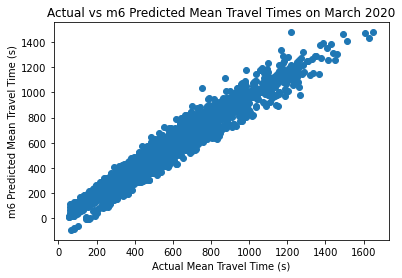

In [153]:
plt.scatter(Y_postlock2, m6_predicted)
plt.title("Actual vs m6 Predicted Mean Travel Times on March 2020")
plt.xlabel("Actual Mean Travel Time (s)")
plt.ylabel("m6 Predicted Mean Travel Time (s)")

Text(0, 0.5, 'Residuals')

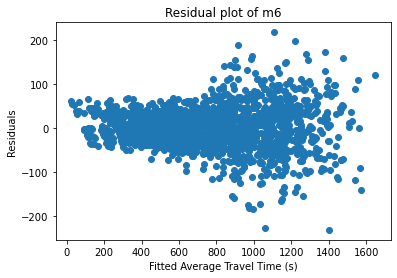

In [154]:
plt.scatter(m6_fitted, Y_prelock2 - m6_fitted)
plt.title("Residual plot of m6")
plt.xlabel("Fitted Average Travel Time (s)")
plt.ylabel("Residuals")

Text(0, 0.5, 'R^2 score of Actual Speed vs Predicted Speeds from Model')

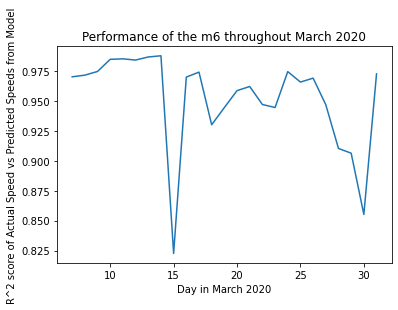

In [155]:
scores6 = []
days6 = []
for day in range(6, 32):
    thisday = final_reset[final_reset["day"] == day]
    X_day = thisday[["distance", "Wind(mph)", "Precipitation (in.)", "weekend", "pastdays", "change"]]
    y_day = pd.Series(thisday["Mean Travel Time (Seconds)"])
    try: 
        scores6.append(m6.score(X_day, y_day))
        days6.append(day)
    except:
        pass
plt.plot(days6, scores6)
plt.title("Performance of the m6 throughout March 2020")
plt.xlabel("Day in March 2020")
plt.ylabel("R^2 score of Actual Speed vs Predicted Speeds from Model")

In [156]:
print("6th Model: m6")
print("Training RMSE: {}".format(rmse(m6_fitted,Y_prelock2)))
print("Training R^2: {}".format(m6.score(X_prelock2, Y_prelock2)))
print("Testing RMSE: {}".format(rmse(m6_predicted,Y_postlock2)))
print("Testing R^2: {}".format(m6.score(X_postlock2, Y_postlock2)))

6th Model: m6
Training RMSE: 47.27622754513598
Training R^2: 0.9799863190071924
Testing RMSE: 61.19785907031438
Testing R^2: 0.9473674514789456


In [157]:
print("Regression coefs for m6:")
print("Distance: {}".format(m6.coef_[0]))
print("Wind(mph): {}".format(m6.coef_[1]))
print("Precipitation (in.): {}".format(m6.coef_[2]))
print("weekend/weekday: {}".format(m6.coef_[3]))
print("Mean of past 5 days' travel times: {}".format(m6.coef_[4]))
print("Change between previous day and this day: {}".format(m6.coef_[5]))

Regression coefs for m6:
Distance: -99.86073291343264
Wind(mph): 5.492292377723789
Precipitation (in.): -307.6751409725531
weekend/weekday: -46.55365279165532
Mean of past 5 days' travel times: 0.9846339373146602
Change between previous day and this day: 0.5984630438049435


---

To double-check your work, the cell below will rerun all of the autograder tests.

In [158]:
grader.check_all()

q1a results: All test cases passed!

q1bi results: All test cases passed!

q1bii results: All test cases passed!

q1biii results: All test cases passed!

q1biv results: All test cases passed!

q1bv3 results: All test cases passed!

q1ci results: All test cases passed!

q1cii results: All test cases passed!

q1ciii results: All test cases passed!

q1civ3 results: All test cases passed!

q2ai2 results: All test cases passed!

q2ai3 results: All test cases passed!

q2ai4 results: All test cases passed!

q2aii2 results: All test cases passed!

q2aiii results: All test cases passed!

q2aiv3 results: All test cases passed!

q2av2 results: All test cases passed!

q4ai1 results: All test cases passed!

q4ai2 results: All test cases passed!

q4ai3 results: All test cases passed!

q4aii2 results: All test cases passed!

q4bi1 results: All test cases passed!

q4ci2 results: All test cases passed!

q4ci3 results: All test cases passed!

q4ci4 results:
    q4ci4 - 1 result:
        Trying:
        

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [159]:
# Save your notebook first, then run this cell to export your submission.
grader.export()